<a href="https://colab.research.google.com/github/LeoMcBills/ML_malariaDiagnosis/blob/main/Tensorflow/basics1/malariaPredictionmbubesa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Input, Dropout, RandomFlip
from keras.src.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
import albumentations as A
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalseNegatives, FalsePositives, Precision, Recall, BinaryAccuracy, AUC
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint

In [2]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=["train"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteQ83Z16/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [4]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
  val_testdataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_testdataset.take(int(VAL_RATIO*DATASET_SIZE))
  test_dataset = val_testdataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [5]:
train_dataset, val_dataset, test_dataset = split(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()),
      list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

In [6]:
for data in dataset[0].take(1):
  print(data)

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


# Data visualizaion

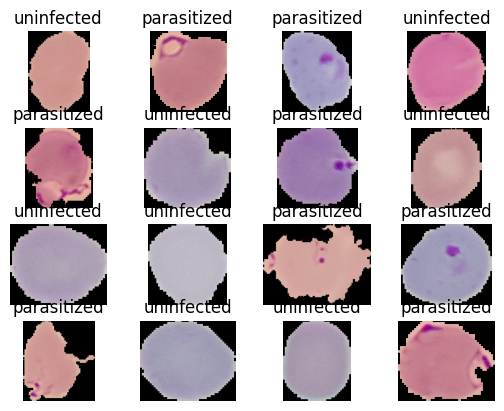

In [7]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

# IMAGE PROCESSING

In [8]:
def visualize(original, augmented):
  plt.subplot(1, 2, 1)
  plt.imshow(original)

  plt.subplot(1, 2, 2)
  plt.imshow(augmented)

In [9]:
original_image, label = next(iter(train_dataset))

In [10]:
augmented_image = tf.image.flip_left_right(original_image)

In [11]:
augmented_image2 = tf.image.random_flip_up_down(original_image)

In [12]:
augmented_image3 = tf.image.rot90(original_image)

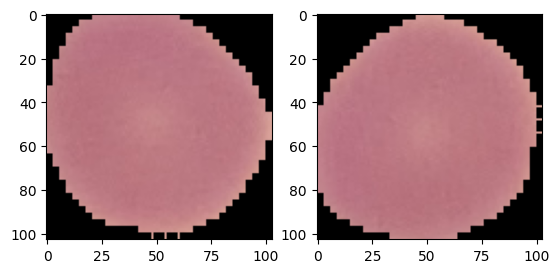

In [13]:
visualize(original_image, augmented_image3)

# Albumentation

In [14]:
# IM_SIZE = 224
# transforms = A.Compose([
#     A.Resize(IM_SIZE, IM_SIZE),
#     A.OneOf([
#         A.HorizontalFlip(),
#         A.VerticalFlip(),], p = 0.3),
#     A.RandomRotate90(),
#     # A.RandomGridShuffle(),
# ])

In [15]:
# def aug_albument(image):
#   data = {"image":image}
#   image = transforms(**data)
#   image = image["image"]
#   image = tf.cast(image/255., tf.float32)
#   return image

In [16]:
# def process_data(image, label):
#   aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
#   return aug_img, label

# Data Processing

In [17]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [18]:
# tf.image augment
def augment(image, label):
  image, label = resize_rescale(image, label)
  image = tf.image.rot90(image)
  # image = tf.adjust_saturation(image, saturation_factor = 0.3)
  image = tf.image.flip_left_right(image)
  return image, label

In [19]:
# tf.keras.layer augment
# augment_layers = tf.keras.Sequential([

# ])

In [20]:
train_dataset = (
    train_dataset
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    .map(augment)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
    )

In [21]:
# train_dataset = (
#     train_dataset
#     .shuffle(buffer_size=8, reshuffle_each_iteration=True)
#     .map(process_data)
#     .batch(32)
#     .prefetch(tf.data.AUTOTUNE)
#     )

In [22]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [23]:
# im, _ = next(iter(train_dataset))
# plt.imshow(im[0])

In [24]:
val_dataset = (
    val_dataset
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    .map(resize_rescale)
    .batch(32).prefetch(tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
    )

In [25]:
train_dataset = train_dataset.map(augment)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [26]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

# Model creation

In [27]:
model = tf.keras.Sequential([
                            InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

                            Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2, strides=2),

                            Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2, strides=2),

                            Flatten(),

                            Dense(1000, activation='sigmoid'),
                            BatchNormalization(),
                            Dense(100, activation='sigmoid'),
                            BatchNormalization(),
                            Dense(1, activation="sigmoid"),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

# Functional API

In [28]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name='Input image')

x = Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Flatten()(x)

x = Dense(1000, activation='sigmoid')(x)
x = BatchNormalization()(x)

x = Dense(100, activation='sigmoid')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

model = Model(func_input, func_output, name="Model")
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)      64    

In [29]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name='Input image')

x = Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

feature_extractor = Model(func_input, output, name="feature_extractor")
feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_8 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_9 (Bat  (None, 109, 109, 16)

In [30]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name='Input image')

x = feature_extractor(func_input)

x = Flatten()(x)

x = Dense(1000, activation='sigmoid')(x)
x = BatchNormalization()(x)

x = Dense(100, activation='sigmoid')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

model = Model(func_input, func_output, name="Model")
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Functio  (None, 54, 54, 16)        1136      
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 1000)              46657000  
                                                                 
 batch_normalization_10 (Ba  (None, 1000)              4000      
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 100)               100100

# Model Subclassing

In [31]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size=pool_size, strides=2*strides)

    self.conv_2 = Conv2D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=pool_size, strides=2*strides)

  def call(self, x):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

# Metrics

In [32]:
metrics = [BinaryAccuracy(name="accuracy"), TruePositives(name='tp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           FalsePositives(name='fp'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

# CallBacks

In [33]:
# Callback
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))

  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))

In [34]:
# CSVLogger
csvlogger = CSVLogger(
    'logs.csv', separator=',', append=False
)

In [35]:
# EarlyStopping
earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

In [36]:
# Learning rate schedular
def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lrSchedular = LearningRateScheduler(scheduler, verbose=1)

In [37]:
# Model checkpointing
checkPoint = ModelCheckpoint(
    'checkpoint/',
    monitor = 'val_loss',
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq=3,
)

In [43]:
def custom_bce(y_true, y_pred):
  bce = BinaryCrossentropy()
  return bce(y_true, y_pred)

In [44]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss=custom_bce,
              metrics=metrics)

# Training

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1,
                    callbacks=[csvlogger, earlystopping, lrSchedular, checkPoint])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/10
  2/689 [..............................] - ETA: 44s - loss: 0.6931 - accuracy: 0.5270 - tp: 983.0000 - tn: 383.0000 - fn: 362.0000 - fp: 864.0000 - precision: 0.5322 - recall: 0.7309 - auc: 0.5395  

  5/689 [..............................] - ETA: 45s - loss: 0.6836 - accuracy: 0.5305 - tp: 1031.0000 - tn: 395.0000 - fn: 370.0000 - fp: 892.0000 - precision: 0.5361 - recall: 0.7359 - auc: 0.5403

  8/689 [..............................] - ETA: 47s - loss: 0.6999 - accuracy: 0.5266 - tp: 1067.0000 - tn: 399.0000 - fn: 382.0000 - fp: 936.0000 - precision: 0.5327 - recall: 0.7364 - auc: 0.5360

 10/689 [..............................] - ETA: 52s - loss: 0.6997 - accuracy: 0.5267 - tp: 1094.0000 - tn: 406.0000 - fn: 386.0000 - fp: 962.0000 - precision: 0.5321 - recall: 0.7392 - auc: 0.5362

 14/689 [..............................] - ETA: 56s - loss: 0.6942 - accuracy: 0.5302 - tp: 1161.0000 - tn: 417.0000 - fn: 392.0000 - fp: 1006.0000 - precision: 0.5358 - recall: 0.7476 - auc: 0.5382

 16/689 [..............................] - ETA: 1:00 - loss: 0.6948 - accuracy: 0.5296 - tp: 1189.0000 - tn: 421.0000 - fn: 393.0000 - fp: 1037.0000 - precision: 0.5341 - recall: 0.7516 - auc: 0.5374

 20/689 [..............................] - ETA: 1:00 - loss: 0.6950 - accuracy: 0.5275 - tp: 1242.0000 - tn: 429.0000 - fn: 397.0000 - fp: 1100.0000 - precision: 0.5303 - recall: 0.7578 - auc: 0.5383

 23/689 [>.............................] - ETA: 1:01 - loss: 0.6938 - accuracy: 0.5306 - tp: 1285.0000 - tn: 447.0000 - fn: 405.0000 - fp: 1127.0000 - precision: 0.5328 - recall: 0.7604 - auc: 0.5391

 26/689 [>.............................] - ETA: 1:01 - loss: 0.6930 - accuracy: 0.5318 - tp: 1320.0000 - tn: 467.0000 - fn: 415.0000 - fp: 1158.0000 - precision: 0.5327 - recall: 0.7608 - auc: 0.5408

 29/689 [>.............................] - ETA: 1:00 - loss: 0.6941 - accuracy: 0.5298 - tp: 1353.0000 - tn: 478.0000 - fn: 430.0000 - fp: 1195.0000 - precision: 0.5310 - recall: 0.7588 - auc: 0.5395

 32/689 [>.............................] - ETA: 1:01 - loss: 0.6938 - accuracy: 0.5290 - tp: 1378.0000 - tn: 501.0000 - fn: 461.0000 - fp: 1212.0000 - precision: 0.5320 - recall: 0.7493 - auc: 0.5373

 35/689 [>.............................] - ETA: 1:04 - loss: 0.6930 - accuracy: 0.5310 - tp: 1419.0000 - tn: 518.0000 - fn: 469.0000 - fp: 1242.0000 - precision: 0.5333 - recall: 0.7516 - auc: 0.5384

 38/689 [>.............................] - ETA: 1:10 - loss: 0.6914 - accuracy: 0.5334 - tp: 1464.0000 - tn: 533.0000 - fn: 486.0000 - fp: 1261.0000 - precision: 0.5372 - recall: 0.7508 - auc: 0.5411

 41/689 [>.............................] - ETA: 1:14 - loss: 0.6903 - accuracy: 0.5349 - tp: 1504.0000 - tn: 550.0000 - fn: 499.0000 - fp: 1287.0000 - precision: 0.5389 - recall: 0.7509 - auc: 0.5434

 44/689 [>.............................] - ETA: 1:17 - loss: 0.6894 - accuracy: 0.5366 - tp: 1545.0000 - tn: 567.0000 - fn: 506.0000 - fp: 1318.0000 - precision: 0.5396 - recall: 0.7533 - auc: 0.5460

 47/689 [=>............................] - ETA: 1:19 - loss: 0.6903 - accuracy: 0.5372 - tp: 1585.0000 - tn: 581.0000 - fn: 511.0000 - fp: 1355.0000 - precision: 0.5391 - recall: 0.7562 - auc: 0.5452

 50/689 [=>............................] - ETA: 1:22 - loss: 0.6899 - accuracy: 0.5380 - tp: 1625.0000 - tn: 596.0000 - fn: 525.0000 - fp: 1382.0000 - precision: 0.5404 - recall: 0.7558 - auc: 0.5467

 53/689 [=>............................] - ETA: 1:22 - loss: 0.6908 - accuracy: 0.5376 - tp: 1660.0000 - tn: 611.0000 - fn: 543.0000 - fp: 1410.0000 - precision: 0.5407 - recall: 0.7535 - auc: 0.5455

 56/689 [=>............................] - ETA: 1:23 - loss: 0.6906 - accuracy: 0.5380 - tp: 1697.0000 - tn: 627.0000 - fn: 554.0000 - fp: 1442.0000 - precision: 0.5406 - recall: 0.7539 - auc: 0.5462

 59/689 [=>............................] - ETA: 1:22 - loss: 0.6907 - accuracy: 0.5374 - tp: 1726.0000 - tn: 647.0000 - fn: 566.0000 - fp: 1477.0000 - precision: 0.5389 - recall: 0.7531 - auc: 0.5466

 62/689 [=>............................] - ETA: 1:20 - loss: 0.6912 - accuracy: 0.5357 - tp: 1738.0000 - tn: 679.0000 - fn: 600.0000 - fp: 1495.0000 - precision: 0.5376 - recall: 0.7434 - auc: 0.5453

 65/689 [=>............................] - ETA: 1:25 - loss: 0.6916 - accuracy: 0.5339 - tp: 1739.0000 - tn: 721.0000 - fn: 653.0000 - fp: 1495.0000 - precision: 0.5377 - recall: 0.7270 - auc: 0.5434

 68/689 [=>............................] - ETA: 1:25 - loss: 0.6918 - accuracy: 0.5321 - tp: 1746.0000 - tn: 757.0000 - fn: 698.0000 - fp: 1503.0000 - precision: 0.5374 - recall: 0.7144 - auc: 0.5419

 71/689 [==>...........................] - ETA: 1:30 - loss: 0.6922 - accuracy: 0.5298 - tp: 1783.0000 - tn: 760.0000 - fn: 710.0000 - fp: 1547.0000 - precision: 0.5354 - recall: 0.7152 - auc: 0.5406

 74/689 [==>...........................] - ETA: 1:28 - loss: 0.6917 - accuracy: 0.5312 - tp: 1836.0000 - tn: 765.0000 - fn: 711.0000 - fp: 1584.0000 - precision: 0.5368 - recall: 0.7208 - auc: 0.5408

 77/689 [==>...........................] - ETA: 1:27 - loss: 0.6920 - accuracy: 0.5298 - tp: 1880.0000 - tn: 765.0000 - fn: 714.0000 - fp: 1633.0000 - precision: 0.5352 - recall: 0.7247 - auc: 0.5392

 80/689 [==>...........................] - ETA: 1:26 - loss: 0.6916 - accuracy: 0.5303 - tp: 1933.0000 - tn: 765.0000 - fn: 715.0000 - fp: 1675.0000 - precision: 0.5358 - recall: 0.7300 - auc: 0.5397

 83/689 [==>...........................] - ETA: 1:25 - loss: 0.6917 - accuracy: 0.5295 - tp: 1980.0000 - tn: 765.0000 - fn: 717.0000 - fp: 1722.0000 - precision: 0.5348 - recall: 0.7341 - auc: 0.5384

 86/689 [==>...........................] - ETA: 1:23 - loss: 0.6921 - accuracy: 0.5282 - tp: 2023.0000 - tn: 766.0000 - fn: 717.0000 - fp: 1774.0000 - precision: 0.5328 - recall: 0.7383 - auc: 0.5368

 89/689 [==>...........................] - ETA: 1:22 - loss: 0.6928 - accuracy: 0.5272 - tp: 2067.0000 - tn: 767.0000 - fn: 717.0000 - fp: 1825.0000 - precision: 0.5311 - recall: 0.7425 - auc: 0.5353

 92/689 [===>..........................] - ETA: 1:21 - loss: 0.6929 - accuracy: 0.5261 - tp: 2112.0000 - tn: 767.0000 - fn: 717.0000 - fp: 1876.0000 - precision: 0.5296 - recall: 0.7466 - auc: 0.5354

 95/689 [===>..........................] - ETA: 1:19 - loss: 0.6930 - accuracy: 0.5257 - tp: 2145.0000 - tn: 782.0000 - fn: 731.0000 - fp: 1910.0000 - precision: 0.5290 - recall: 0.7458 - auc: 0.5353

 98/689 [===>..........................] - ETA: 1:18 - loss: 0.6930 - accuracy: 0.5261 - tp: 2153.0000 - tn: 827.0000 - fn: 766.0000 - fp: 1918.0000 - precision: 0.5289 - recall: 0.7376 - auc: 0.5359

101/689 [===>..........................] - ETA: 1:17 - loss: 0.6929 - accuracy: 0.5259 - tp: 2157.0000 - tn: 872.0000 - fn: 812.0000 - fp: 1919.0000 - precision: 0.5292 - recall: 0.7265 - auc: 0.5358

104/689 [===>..........................] - ETA: 1:16 - loss: 0.6924 - accuracy: 0.5273 - tp: 2161.0000 - tn: 927.0000 - fn: 845.0000 - fp: 1923.0000 - precision: 0.5291 - recall: 0.7189 - auc: 0.5387

107/689 [===>..........................] - ETA: 1:15 - loss: 0.6924 - accuracy: 0.5265 - tp: 2165.0000 - tn: 969.0000 - fn: 890.0000 - fp: 1928.0000 - precision: 0.5290 - recall: 0.7087 - auc: 0.5378

110/689 [===>..........................] - ETA: 1:15 - loss: 0.6924 - accuracy: 0.5260 - tp: 2171.0000 - tn: 1010.0000 - fn: 932.0000 - fp: 1935.0000 - precision: 0.5287 - recall: 0.6996 - auc: 0.5370

113/689 [===>..........................] - ETA: 1:14 - loss: 0.6926 - accuracy: 0.5259 - tp: 2183.0000 - tn: 1048.0000 - fn: 967.0000 - fp: 1946.0000 - precision: 0.5287 - recall: 0.6930 - auc: 0.5369

116/689 [====>.........................] - ETA: 1:13 - loss: 0.6917 - accuracy: 0.5266 - tp: 2198.0000 - tn: 1088.0000 - fn: 1001.0000 - fp: 1953.0000 - precision: 0.5295 - recall: 0.6871 - auc: 0.5385

119/689 [====>.........................] - ETA: 1:12 - loss: 0.6914 - accuracy: 0.5275 - tp: 2216.0000 - tn: 1126.0000 - fn: 1025.0000 - fp: 1969.0000 - precision: 0.5295 - recall: 0.6837 - auc: 0.5395

122/689 [====>.........................] - ETA: 1:12 - loss: 0.6916 - accuracy: 0.5285 - tp: 2241.0000 - tn: 1158.0000 - fn: 1048.0000 - fp: 1985.0000 - precision: 0.5303 - recall: 0.6814 - auc: 0.5405

125/689 [====>.........................] - ETA: 1:11 - loss: 0.6912 - accuracy: 0.5290 - tp: 2260.0000 - tn: 1193.0000 - fn: 1068.0000 - fp: 2007.0000 - precision: 0.5296 - recall: 0.6791 - auc: 0.5414

128/689 [====>.........................] - ETA: 1:10 - loss: 0.6912 - accuracy: 0.5290 - tp: 2278.0000 - tn: 1226.0000 - fn: 1096.0000 - fp: 2024.0000 - precision: 0.5295 - recall: 0.6752 - auc: 0.5412

131/689 [====>.........................] - ETA: 1:10 - loss: 0.6908 - accuracy: 0.5307 - tp: 2305.0000 - tn: 1261.0000 - fn: 1122.0000 - fp: 2032.0000 - precision: 0.5315 - recall: 0.6726 - auc: 0.5427

134/689 [====>.........................] - ETA: 1:09 - loss: 0.6905 - accuracy: 0.5311 - tp: 2323.0000 - tn: 1297.0000 - fn: 1143.0000 - fp: 2053.0000 - precision: 0.5309 - recall: 0.6702 - auc: 0.5438

137/689 [====>.........................] - ETA: 1:08 - loss: 0.6906 - accuracy: 0.5314 - tp: 2353.0000 - tn: 1320.0000 - fn: 1170.0000 - fp: 2069.0000 - precision: 0.5321 - recall: 0.6679 - auc: 0.5433

140/689 [=====>........................] - ETA: 1:07 - loss: 0.6905 - accuracy: 0.5318 - tp: 2384.0000 - tn: 1343.0000 - fn: 1191.0000 - fp: 2090.0000 - precision: 0.5329 - recall: 0.6669 - auc: 0.5439

143/689 [=====>........................] - ETA: 1:07 - loss: 0.6900 - accuracy: 0.5325 - tp: 2416.0000 - tn: 1367.0000 - fn: 1202.0000 - fp: 2119.0000 - precision: 0.5327 - recall: 0.6678 - auc: 0.5457

146/689 [=====>........................] - ETA: 1:08 - loss: 0.6896 - accuracy: 0.5336 - tp: 2453.0000 - tn: 1389.0000 - fn: 1213.0000 - fp: 2145.0000 - precision: 0.5335 - recall: 0.6691 - auc: 0.5471

149/689 [=====>........................] - ETA: 1:08 - loss: 0.6892 - accuracy: 0.5340 - tp: 2491.0000 - tn: 1405.0000 - fn: 1225.0000 - fp: 2175.0000 - precision: 0.5339 - recall: 0.6703 - auc: 0.5482

152/689 [=====>........................] - ETA: 1:08 - loss: 0.6889 - accuracy: 0.5344 - tp: 2531.0000 - tn: 1419.0000 - fn: 1241.0000 - fp: 2201.0000 - precision: 0.5349 - recall: 0.6710 - auc: 0.5489

155/689 [=====>........................] - ETA: 1:08 - loss: 0.6891 - accuracy: 0.5337 - tp: 2567.0000 - tn: 1429.0000 - fn: 1249.0000 - fp: 2243.0000 - precision: 0.5337 - recall: 0.6727 - auc: 0.5481

158/689 [=====>........................] - ETA: 1:08 - loss: 0.6891 - accuracy: 0.5328 - tp: 2605.0000 - tn: 1436.0000 - fn: 1253.0000 - fp: 2290.0000 - precision: 0.5322 - recall: 0.6752 - auc: 0.5470

161/689 [======>.......................] - ETA: 1:09 - loss: 0.6887 - accuracy: 0.5336 - tp: 2651.0000 - tn: 1447.0000 - fn: 1257.0000 - fp: 2325.0000 - precision: 0.5328 - recall: 0.6784 - auc: 0.5485

164/689 [======>.......................] - ETA: 1:08 - loss: 0.6885 - accuracy: 0.5341 - tp: 2688.0000 - tn: 1465.0000 - fn: 1279.0000 - fp: 2344.0000 - precision: 0.5342 - recall: 0.6776 - auc: 0.5492

167/689 [======>.......................] - ETA: 1:08 - loss: 0.6886 - accuracy: 0.5344 - tp: 2711.0000 - tn: 1496.0000 - fn: 1296.0000 - fp: 2369.0000 - precision: 0.5337 - recall: 0.6766 - auc: 0.5491

170/689 [======>.......................] - ETA: 1:07 - loss: 0.6879 - accuracy: 0.5355 - tp: 2736.0000 - tn: 1531.0000 - fn: 1318.0000 - fp: 2383.0000 - precision: 0.5345 - recall: 0.6749 - auc: 0.5515

173/689 [======>.......................] - ETA: 1:07 - loss: 0.6874 - accuracy: 0.5366 - tp: 2766.0000 - tn: 1561.0000 - fn: 1341.0000 - fp: 2396.0000 - precision: 0.5358 - recall: 0.6735 - auc: 0.5531

176/689 [======>.......................] - ETA: 1:06 - loss: 0.6875 - accuracy: 0.5369 - tp: 2797.0000 - tn: 1584.0000 - fn: 1352.0000 - fp: 2427.0000 - precision: 0.5354 - recall: 0.6741 - auc: 0.5530

179/689 [======>.......................] - ETA: 1:06 - loss: 0.6870 - accuracy: 0.5374 - tp: 2829.0000 - tn: 1608.0000 - fn: 1363.0000 - fp: 2456.0000 - precision: 0.5353 - recall: 0.6749 - auc: 0.5543

182/689 [======>.......................] - ETA: 1:05 - loss: 0.6867 - accuracy: 0.5381 - tp: 2854.0000 - tn: 1640.0000 - fn: 1384.0000 - fp: 2474.0000 - precision: 0.5357 - recall: 0.6734 - auc: 0.5552

185/689 [=======>......................] - ETA: 1:05 - loss: 0.6862 - accuracy: 0.5389 - tp: 2882.0000 - tn: 1671.0000 - fn: 1403.0000 - fp: 2492.0000 - precision: 0.5363 - recall: 0.6726 - auc: 0.5567

188/689 [=======>......................] - ETA: 1:04 - loss: 0.6865 - accuracy: 0.5382 - tp: 2900.0000 - tn: 1698.0000 - fn: 1441.0000 - fp: 2505.0000 - precision: 0.5365 - recall: 0.6680 - auc: 0.5554

191/689 [=======>......................] - ETA: 1:04 - loss: 0.6865 - accuracy: 0.5396 - tp: 2938.0000 - tn: 1724.0000 - fn: 1457.0000 - fp: 2521.0000 - precision: 0.5382 - recall: 0.6685 - auc: 0.5570

193/689 [=======>......................] - ETA: 1:03 - loss: 0.6864 - accuracy: 0.5401 - tp: 2961.0000 - tn: 1740.0000 - fn: 1467.0000 - fp: 2536.0000 - precision: 0.5387 - recall: 0.6687 - auc: 0.5575

197/689 [=======>......................] - ETA: 1:02 - loss: 0.6868 - accuracy: 0.5408 - tp: 3013.0000 - tn: 1763.0000 - fn: 1479.0000 - fp: 2577.0000 - precision: 0.5390 - recall: 0.6707 - auc: 0.5574

199/689 [=======>......................] - ETA: 1:02 - loss: 0.6864 - accuracy: 0.5417 - tp: 3042.0000 - tn: 1777.0000 - fn: 1482.0000 - fp: 2595.0000 - precision: 0.5396 - recall: 0.6724 - auc: 0.5586

203/689 [=======>......................] - ETA: 1:01 - loss: 0.6863 - accuracy: 0.5427 - tp: 3104.0000 - tn: 1793.0000 - fn: 1490.0000 - fp: 2637.0000 - precision: 0.5407 - recall: 0.6757 - auc: 0.5595

206/689 [=======>......................] - ETA: 1:01 - loss: 0.6864 - accuracy: 0.5431 - tp: 3147.0000 - tn: 1806.0000 - fn: 1495.0000 - fp: 2672.0000 - precision: 0.5408 - recall: 0.6779 - auc: 0.5599

209/689 [========>.....................] - ETA: 1:00 - loss: 0.6865 - accuracy: 0.5430 - tp: 3181.0000 - tn: 1823.0000 - fn: 1501.0000 - fp: 2711.0000 - precision: 0.5399 - recall: 0.6794 - auc: 0.5594

212/689 [========>.....................] - ETA: 1:00 - loss: 0.6862 - accuracy: 0.5440 - tp: 3210.0000 - tn: 1856.0000 - fn: 1515.0000 - fp: 2731.0000 - precision: 0.5403 - recall: 0.6794 - auc: 0.5606

215/689 [========>.....................] - ETA: 59s - loss: 0.6858 - accuracy: 0.5443 - tp: 3238.0000 - tn: 1883.0000 - fn: 1528.0000 - fp: 2759.0000 - precision: 0.5399 - recall: 0.6794 - auc: 0.5612

217/689 [========>.....................] - ETA: 59s - loss: 0.6855 - accuracy: 0.5449 - tp: 3254.0000 - tn: 1907.0000 - fn: 1544.0000 - fp: 2767.0000 - precision: 0.5404 - recall: 0.6782 - auc: 0.5619

221/689 [========>.....................] - ETA: 58s - loss: 0.6853 - accuracy: 0.5441 - tp: 3260.0000 - tn: 1963.0000 - fn: 1606.0000 - fp: 2771.0000 - precision: 0.5405 - recall: 0.6700 - auc: 0.5617

224/689 [========>.....................] - ETA: 57s - loss: 0.6849 - accuracy: 0.5441 - tp: 3280.0000 - tn: 1996.0000 - fn: 1638.0000 - fp: 2782.0000 - precision: 0.5411 - recall: 0.6669 - auc: 0.5617

227/689 [========>.....................] - ETA: 57s - loss: 0.6850 - accuracy: 0.5441 - tp: 3317.0000 - tn: 2011.0000 - fn: 1648.0000 - fp: 2816.0000 - precision: 0.5408 - recall: 0.6681 - auc: 0.5623

230/689 [=========>....................] - ETA: 57s - loss: 0.6845 - accuracy: 0.5445 - tp: 3351.0000 - tn: 2033.0000 - fn: 1654.0000 - fp: 2850.0000 - precision: 0.5404 - recall: 0.6695 - auc: 0.5632

233/689 [=========>....................] - ETA: 56s - loss: 0.6842 - accuracy: 0.5456 - tp: 3382.0000 - tn: 2065.0000 - fn: 1665.0000 - fp: 2872.0000 - precision: 0.5408 - recall: 0.6701 - auc: 0.5646

236/689 [=========>....................] - ETA: 56s - loss: 0.6831 - accuracy: 0.5474 - tp: 3424.0000 - tn: 2094.0000 - fn: 1680.0000 - fp: 2882.0000 - precision: 0.5430 - recall: 0.6708 - auc: 0.5677

239/689 [=========>....................] - ETA: 55s - loss: 0.6822 - accuracy: 0.5490 - tp: 3459.0000 - tn: 2128.0000 - fn: 1690.0000 - fp: 2899.0000 - precision: 0.5440 - recall: 0.6718 - auc: 0.5703

242/689 [=========>....................] - ETA: 55s - loss: 0.6816 - accuracy: 0.5504 - tp: 3490.0000 - tn: 2164.0000 - fn: 1706.0000 - fp: 2912.0000 - precision: 0.5451 - recall: 0.6717 - auc: 0.5727

245/689 [=========>....................] - ETA: 54s - loss: 0.6809 - accuracy: 0.5516 - tp: 3530.0000 - tn: 2189.0000 - fn: 1720.0000 - fp: 2929.0000 - precision: 0.5465 - recall: 0.6724 - auc: 0.5746

248/689 [=========>....................] - ETA: 54s - loss: 0.6805 - accuracy: 0.5520 - tp: 3570.0000 - tn: 2206.0000 - fn: 1726.0000 - fp: 2962.0000 - precision: 0.5465 - recall: 0.6741 - auc: 0.5751

251/689 [=========>....................] - ETA: 53s - loss: 0.6801 - accuracy: 0.5531 - tp: 3612.0000 - tn: 2229.0000 - fn: 1734.0000 - fp: 2985.0000 - precision: 0.5475 - recall: 0.6756 - auc: 0.5769

254/689 [==========>...................] - ETA: 53s - loss: 0.6808 - accuracy: 0.5536 - tp: 3639.0000 - tn: 2260.0000 - fn: 1748.0000 - fp: 3009.0000 - precision: 0.5474 - recall: 0.6755 - auc: 0.5771

257/689 [==========>...................] - ETA: 52s - loss: 0.6806 - accuracy: 0.5549 - tp: 3677.0000 - tn: 2289.0000 - fn: 1763.0000 - fp: 3023.0000 - precision: 0.5488 - recall: 0.6759 - auc: 0.5790

260/689 [==========>...................] - ETA: 52s - loss: 0.6797 - accuracy: 0.5566 - tp: 3711.0000 - tn: 2327.0000 - fn: 1774.0000 - fp: 3036.0000 - precision: 0.5500 - recall: 0.6766 - auc: 0.5818

263/689 [==========>...................] - ETA: 52s - loss: 0.6788 - accuracy: 0.5579 - tp: 3743.0000 - tn: 2363.0000 - fn: 1785.0000 - fp: 3053.0000 - precision: 0.5508 - recall: 0.6771 - auc: 0.5839

266/689 [==========>...................] - ETA: 51s - loss: 0.6780 - accuracy: 0.5593 - tp: 3781.0000 - tn: 2394.0000 - fn: 1797.0000 - fp: 3068.0000 - precision: 0.5521 - recall: 0.6778 - auc: 0.5861

269/689 [==========>...................] - ETA: 51s - loss: 0.6781 - accuracy: 0.5602 - tp: 3816.0000 - tn: 2422.0000 - fn: 1810.0000 - fp: 3088.0000 - precision: 0.5527 - recall: 0.6783 - auc: 0.5872

272/689 [==========>...................] - ETA: 51s - loss: 0.6773 - accuracy: 0.5613 - tp: 3855.0000 - tn: 2449.0000 - fn: 1827.0000 - fp: 3101.0000 - precision: 0.5542 - recall: 0.6785 - auc: 0.5890

275/689 [==========>...................] - ETA: 51s - loss: 0.6770 - accuracy: 0.5623 - tp: 3889.0000 - tn: 2481.0000 - fn: 1842.0000 - fp: 3116.0000 - precision: 0.5552 - recall: 0.6786 - auc: 0.5907

278/689 [===========>..................] - ETA: 51s - loss: 0.6773 - accuracy: 0.5631 - tp: 3921.0000 - tn: 2512.0000 - fn: 1852.0000 - fp: 3139.0000 - precision: 0.5554 - recall: 0.6792 - auc: 0.5916

281/689 [===========>..................] - ETA: 51s - loss: 0.6768 - accuracy: 0.5641 - tp: 3957.0000 - tn: 2541.0000 - fn: 1864.0000 - fp: 3158.0000 - precision: 0.5561 - recall: 0.6798 - auc: 0.5930

284/689 [===========>..................] - ETA: 51s - loss: 0.6758 - accuracy: 0.5654 - tp: 3996.0000 - tn: 2572.0000 - fn: 1874.0000 - fp: 3174.0000 - precision: 0.5573 - recall: 0.6807 - auc: 0.5951

287/689 [===========>..................] - ETA: 50s - loss: 0.6761 - accuracy: 0.5658 - tp: 4026.0000 - tn: 2601.0000 - fn: 1891.0000 - fp: 3194.0000 - precision: 0.5576 - recall: 0.6804 - auc: 0.5954

290/689 [===========>..................] - ETA: 50s - loss: 0.6758 - accuracy: 0.5666 - tp: 4055.0000 - tn: 2636.0000 - fn: 1905.0000 - fp: 3212.0000 - precision: 0.5580 - recall: 0.6804 - auc: 0.5963

293/689 [===========>..................] - ETA: 49s - loss: 0.6759 - accuracy: 0.5670 - tp: 4084.0000 - tn: 2665.0000 - fn: 1922.0000 - fp: 3233.0000 - precision: 0.5582 - recall: 0.6800 - auc: 0.5965

296/689 [===========>..................] - ETA: 49s - loss: 0.6758 - accuracy: 0.5673 - tp: 4121.0000 - tn: 2687.0000 - fn: 1934.0000 - fp: 3258.0000 - precision: 0.5585 - recall: 0.6806 - auc: 0.5967

299/689 [============>.................] - ETA: 48s - loss: 0.6760 - accuracy: 0.5673 - tp: 4159.0000 - tn: 2703.0000 - fn: 1940.0000 - fp: 3294.0000 - precision: 0.5580 - recall: 0.6819 - auc: 0.5965

302/689 [============>.................] - ETA: 48s - loss: 0.6761 - accuracy: 0.5682 - tp: 4207.0000 - tn: 2721.0000 - fn: 1950.0000 - fp: 3314.0000 - precision: 0.5594 - recall: 0.6833 - auc: 0.5973

305/689 [============>.................] - ETA: 48s - loss: 0.6760 - accuracy: 0.5685 - tp: 4242.0000 - tn: 2744.0000 - fn: 1956.0000 - fp: 3346.0000 - precision: 0.5590 - recall: 0.6844 - auc: 0.5977

308/689 [============>.................] - ETA: 47s - loss: 0.6756 - accuracy: 0.5693 - tp: 4278.0000 - tn: 2772.0000 - fn: 1961.0000 - fp: 3373.0000 - precision: 0.5591 - recall: 0.6857 - auc: 0.5988

311/689 [============>.................] - ETA: 47s - loss: 0.6755 - accuracy: 0.5698 - tp: 4320.0000 - tn: 2791.0000 - fn: 1975.0000 - fp: 3394.0000 - precision: 0.5600 - recall: 0.6863 - auc: 0.5991

314/689 [============>.................] - ETA: 46s - loss: 0.6752 - accuracy: 0.5702 - tp: 4358.0000 - tn: 2813.0000 - fn: 1987.0000 - fp: 3418.0000 - precision: 0.5604 - recall: 0.6868 - auc: 0.5995

316/689 [============>.................] - ETA: 46s - loss: 0.6749 - accuracy: 0.5703 - tp: 4379.0000 - tn: 2830.0000 - fn: 1997.0000 - fp: 3434.0000 - precision: 0.5605 - recall: 0.6868 - auc: 0.5999

320/689 [============>.................] - ETA: 45s - loss: 0.6745 - accuracy: 0.5714 - tp: 4430.0000 - tn: 2865.0000 - fn: 2014.0000 - fp: 3459.0000 - precision: 0.5615 - recall: 0.6875 - auc: 0.6012

322/689 [=============>................] - ETA: 45s - loss: 0.6746 - accuracy: 0.5715 - tp: 4452.0000 - tn: 2881.0000 - fn: 2021.0000 - fp: 3478.0000 - precision: 0.5614 - recall: 0.6878 - auc: 0.6012

326/689 [=============>................] - ETA: 44s - loss: 0.6746 - accuracy: 0.5720 - tp: 4488.0000 - tn: 2925.0000 - fn: 2048.0000 - fp: 3499.0000 - precision: 0.5619 - recall: 0.6867 - auc: 0.6018

329/689 [=============>................] - ETA: 44s - loss: 0.6742 - accuracy: 0.5723 - tp: 4512.0000 - tn: 2960.0000 - fn: 2059.0000 - fp: 3525.0000 - precision: 0.5614 - recall: 0.6867 - auc: 0.6025

331/689 [=============>................] - ETA: 43s - loss: 0.6746 - accuracy: 0.5720 - tp: 4529.0000 - tn: 2976.0000 - fn: 2074.0000 - fp: 3541.0000 - precision: 0.5612 - recall: 0.6859 - auc: 0.6021

335/689 [=============>................] - ETA: 43s - loss: 0.6746 - accuracy: 0.5725 - tp: 4571.0000 - tn: 3013.0000 - fn: 2099.0000 - fp: 3565.0000 - precision: 0.5618 - recall: 0.6853 - auc: 0.6023

338/689 [=============>................] - ETA: 43s - loss: 0.6745 - accuracy: 0.5728 - tp: 4600.0000 - tn: 3044.0000 - fn: 2119.0000 - fp: 3581.0000 - precision: 0.5623 - recall: 0.6846 - auc: 0.6028

341/689 [=============>................] - ETA: 42s - loss: 0.6744 - accuracy: 0.5731 - tp: 4633.0000 - tn: 3070.0000 - fn: 2140.0000 - fp: 3597.0000 - precision: 0.5629 - recall: 0.6840 - auc: 0.6030

344/689 [=============>................] - ETA: 42s - loss: 0.6741 - accuracy: 0.5737 - tp: 4667.0000 - tn: 3099.0000 - fn: 2150.0000 - fp: 3620.0000 - precision: 0.5632 - recall: 0.6846 - auc: 0.6039

347/689 [==============>...............] - ETA: 41s - loss: 0.6741 - accuracy: 0.5738 - tp: 4694.0000 - tn: 3128.0000 - fn: 2161.0000 - fp: 3649.0000 - precision: 0.5626 - recall: 0.6848 - auc: 0.6038

350/689 [==============>...............] - ETA: 41s - loss: 0.6741 - accuracy: 0.5739 - tp: 4723.0000 - tn: 3155.0000 - fn: 2175.0000 - fp: 3675.0000 - precision: 0.5624 - recall: 0.6847 - auc: 0.6038

352/689 [==============>...............] - ETA: 41s - loss: 0.6737 - accuracy: 0.5744 - tp: 4746.0000 - tn: 3176.0000 - fn: 2183.0000 - fp: 3687.0000 - precision: 0.5628 - recall: 0.6849 - auc: 0.6046

355/689 [==============>...............] - ETA: 40s - loss: 0.6728 - accuracy: 0.5755 - tp: 4786.0000 - tn: 3207.0000 - fn: 2196.0000 - fp: 3699.0000 - precision: 0.5641 - recall: 0.6855 - auc: 0.6064

359/689 [==============>...............] - ETA: 40s - loss: 0.6726 - accuracy: 0.5761 - tp: 4831.0000 - tn: 3244.0000 - fn: 2221.0000 - fp: 3720.0000 - precision: 0.5650 - recall: 0.6851 - auc: 0.6073

362/689 [==============>...............] - ETA: 39s - loss: 0.6715 - accuracy: 0.5773 - tp: 4873.0000 - tn: 3274.0000 - fn: 2233.0000 - fp: 3732.0000 - precision: 0.5663 - recall: 0.6858 - auc: 0.6093

365/689 [==============>...............] - ETA: 39s - loss: 0.6715 - accuracy: 0.5776 - tp: 4907.0000 - tn: 3300.0000 - fn: 2241.0000 - fp: 3760.0000 - precision: 0.5662 - recall: 0.6865 - auc: 0.6097

368/689 [===============>..............] - ETA: 38s - loss: 0.6717 - accuracy: 0.5780 - tp: 4937.0000 - tn: 3330.0000 - fn: 2253.0000 - fp: 3784.0000 - precision: 0.5661 - recall: 0.6866 - auc: 0.6099

371/689 [===============>..............] - ETA: 38s - loss: 0.6713 - accuracy: 0.5784 - tp: 4973.0000 - tn: 3356.0000 - fn: 2268.0000 - fp: 3803.0000 - precision: 0.5667 - recall: 0.6868 - auc: 0.6106

374/689 [===============>..............] - ETA: 38s - loss: 0.6712 - accuracy: 0.5787 - tp: 5007.0000 - tn: 3382.0000 - fn: 2280.0000 - fp: 3827.0000 - precision: 0.5668 - recall: 0.6871 - auc: 0.6110

377/689 [===============>..............] - ETA: 37s - loss: 0.6709 - accuracy: 0.5792 - tp: 5046.0000 - tn: 3406.0000 - fn: 2295.0000 - fp: 3845.0000 - precision: 0.5675 - recall: 0.6874 - auc: 0.6118

380/689 [===============>..............] - ETA: 37s - loss: 0.6708 - accuracy: 0.5794 - tp: 5082.0000 - tn: 3428.0000 - fn: 2308.0000 - fp: 3870.0000 - precision: 0.5677 - recall: 0.6877 - auc: 0.6119

383/689 [===============>..............] - ETA: 36s - loss: 0.6703 - accuracy: 0.5801 - tp: 5117.0000 - tn: 3459.0000 - fn: 2315.0000 - fp: 3893.0000 - precision: 0.5679 - recall: 0.6885 - auc: 0.6129

386/689 [===============>..............] - ETA: 36s - loss: 0.6698 - accuracy: 0.5806 - tp: 5152.0000 - tn: 3488.0000 - fn: 2327.0000 - fp: 3913.0000 - precision: 0.5683 - recall: 0.6889 - auc: 0.6138

389/689 [===============>..............] - ETA: 36s - loss: 0.6690 - accuracy: 0.5815 - tp: 5189.0000 - tn: 3520.0000 - fn: 2336.0000 - fp: 3931.0000 - precision: 0.5690 - recall: 0.6896 - auc: 0.6154

392/689 [================>.............] - ETA: 35s - loss: 0.6687 - accuracy: 0.5820 - tp: 5227.0000 - tn: 3545.0000 - fn: 2349.0000 - fp: 3951.0000 - precision: 0.5695 - recall: 0.6899 - auc: 0.6160

395/689 [================>.............] - ETA: 35s - loss: 0.6687 - accuracy: 0.5824 - tp: 5264.0000 - tn: 3570.0000 - fn: 2363.0000 - fp: 3971.0000 - precision: 0.5700 - recall: 0.6902 - auc: 0.6163

398/689 [================>.............] - ETA: 35s - loss: 0.6687 - accuracy: 0.5825 - tp: 5302.0000 - tn: 3590.0000 - fn: 2379.0000 - fp: 3993.0000 - precision: 0.5704 - recall: 0.6903 - auc: 0.6165

401/689 [================>.............] - ETA: 35s - loss: 0.6682 - accuracy: 0.5831 - tp: 5343.0000 - tn: 3613.0000 - fn: 2386.0000 - fp: 4018.0000 - precision: 0.5708 - recall: 0.6913 - auc: 0.6172

404/689 [================>.............] - ETA: 35s - loss: 0.6686 - accuracy: 0.5832 - tp: 5381.0000 - tn: 3633.0000 - fn: 2396.0000 - fp: 4046.0000 - precision: 0.5708 - recall: 0.6919 - auc: 0.6171

407/689 [================>.............] - ETA: 34s - loss: 0.6688 - accuracy: 0.5829 - tp: 5420.0000 - tn: 3646.0000 - fn: 2402.0000 - fp: 4084.0000 - precision: 0.5703 - recall: 0.6929 - auc: 0.6168

410/689 [================>.............] - ETA: 34s - loss: 0.6686 - accuracy: 0.5829 - tp: 5459.0000 - tn: 3663.0000 - fn: 2408.0000 - fp: 4118.0000 - precision: 0.5700 - recall: 0.6939 - auc: 0.6169

413/689 [================>.............] - ETA: 34s - loss: 0.6687 - accuracy: 0.5830 - tp: 5495.0000 - tn: 3683.0000 - fn: 2423.0000 - fp: 4143.0000 - precision: 0.5701 - recall: 0.6940 - auc: 0.6169

416/689 [=================>............] - ETA: 33s - loss: 0.6687 - accuracy: 0.5835 - tp: 5531.0000 - tn: 3711.0000 - fn: 2434.0000 - fp: 4164.0000 - precision: 0.5705 - recall: 0.6944 - auc: 0.6171

419/689 [=================>............] - ETA: 33s - loss: 0.6684 - accuracy: 0.5841 - tp: 5571.0000 - tn: 3737.0000 - fn: 2444.0000 - fp: 4184.0000 - precision: 0.5711 - recall: 0.6951 - auc: 0.6178

422/689 [=================>............] - ETA: 32s - loss: 0.6683 - accuracy: 0.5842 - tp: 5612.0000 - tn: 3754.0000 - fn: 2451.0000 - fp: 4215.0000 - precision: 0.5711 - recall: 0.6960 - auc: 0.6180

425/689 [=================>............] - ETA: 32s - loss: 0.6677 - accuracy: 0.5853 - tp: 5654.0000 - tn: 3785.0000 - fn: 2457.0000 - fp: 4232.0000 - precision: 0.5719 - recall: 0.6971 - auc: 0.6195

428/689 [=================>............] - ETA: 32s - loss: 0.6675 - accuracy: 0.5856 - tp: 5690.0000 - tn: 3810.0000 - fn: 2473.0000 - fp: 4251.0000 - precision: 0.5724 - recall: 0.6970 - auc: 0.6199

431/689 [=================>............] - ETA: 31s - loss: 0.6671 - accuracy: 0.5862 - tp: 5728.0000 - tn: 3839.0000 - fn: 2493.0000 - fp: 4260.0000 - precision: 0.5735 - recall: 0.6968 - auc: 0.6210

434/689 [=================>............] - ETA: 31s - loss: 0.6673 - accuracy: 0.5863 - tp: 5756.0000 - tn: 3869.0000 - fn: 2508.0000 - fp: 4283.0000 - precision: 0.5734 - recall: 0.6965 - auc: 0.6209

437/689 [==================>...........] - ETA: 30s - loss: 0.6671 - accuracy: 0.5870 - tp: 5796.0000 - tn: 3896.0000 - fn: 2517.0000 - fp: 4303.0000 - precision: 0.5739 - recall: 0.6972 - auc: 0.6218

440/689 [==================>...........] - ETA: 30s - loss: 0.6671 - accuracy: 0.5874 - tp: 5829.0000 - tn: 3926.0000 - fn: 2531.0000 - fp: 4322.0000 - precision: 0.5742 - recall: 0.6972 - auc: 0.6224

443/689 [==================>...........] - ETA: 30s - loss: 0.6669 - accuracy: 0.5872 - tp: 5856.0000 - tn: 3953.0000 - fn: 2552.0000 - fp: 4343.0000 - precision: 0.5742 - recall: 0.6965 - auc: 0.6223

446/689 [==================>...........] - ETA: 29s - loss: 0.6675 - accuracy: 0.5870 - tp: 5872.0000 - tn: 3990.0000 - fn: 2580.0000 - fp: 4358.0000 - precision: 0.5740 - recall: 0.6947 - auc: 0.6219

449/689 [==================>...........] - ETA: 29s - loss: 0.6672 - accuracy: 0.5876 - tp: 5901.0000 - tn: 4027.0000 - fn: 2603.0000 - fp: 4365.0000 - precision: 0.5748 - recall: 0.6939 - auc: 0.6226

452/689 [==================>...........] - ETA: 28s - loss: 0.6673 - accuracy: 0.5877 - tp: 5921.0000 - tn: 4065.0000 - fn: 2623.0000 - fp: 4383.0000 - precision: 0.5746 - recall: 0.6930 - auc: 0.6227

455/689 [==================>...........] - ETA: 28s - loss: 0.6672 - accuracy: 0.5877 - tp: 5952.0000 - tn: 4090.0000 - fn: 2649.0000 - fp: 4397.0000 - precision: 0.5751 - recall: 0.6920 - auc: 0.6229

458/689 [==================>...........] - ETA: 28s - loss: 0.6671 - accuracy: 0.5880 - tp: 5986.0000 - tn: 4118.0000 - fn: 2666.0000 - fp: 4414.0000 - precision: 0.5756 - recall: 0.6919 - auc: 0.6232

461/689 [===================>..........] - ETA: 27s - loss: 0.6667 - accuracy: 0.5884 - tp: 6021.0000 - tn: 4147.0000 - fn: 2675.0000 - fp: 4437.0000 - precision: 0.5757 - recall: 0.6924 - auc: 0.6239

464/689 [===================>..........] - ETA: 27s - loss: 0.6664 - accuracy: 0.5891 - tp: 6057.0000 - tn: 4180.0000 - fn: 2683.0000 - fp: 4456.0000 - precision: 0.5761 - recall: 0.6930 - auc: 0.6247

467/689 [===================>..........] - ETA: 26s - loss: 0.6663 - accuracy: 0.5895 - tp: 6093.0000 - tn: 4206.0000 - fn: 2694.0000 - fp: 4479.0000 - precision: 0.5763 - recall: 0.6934 - auc: 0.6249

470/689 [===================>..........] - ETA: 26s - loss: 0.6660 - accuracy: 0.5900 - tp: 6128.0000 - tn: 4237.0000 - fn: 2707.0000 - fp: 4496.0000 - precision: 0.5768 - recall: 0.6936 - auc: 0.6257

473/689 [===================>..........] - ETA: 26s - loss: 0.6656 - accuracy: 0.5904 - tp: 6157.0000 - tn: 4271.0000 - fn: 2726.0000 - fp: 4510.0000 - precision: 0.5772 - recall: 0.6931 - auc: 0.6263

476/689 [===================>..........] - ETA: 25s - loss: 0.6651 - accuracy: 0.5908 - tp: 6187.0000 - tn: 4306.0000 - fn: 2742.0000 - fp: 4525.0000 - precision: 0.5776 - recall: 0.6929 - auc: 0.6271

479/689 [===================>..........] - ETA: 25s - loss: 0.6650 - accuracy: 0.5911 - tp: 6222.0000 - tn: 4333.0000 - fn: 2754.0000 - fp: 4547.0000 - precision: 0.5778 - recall: 0.6932 - auc: 0.6276

482/689 [===================>..........] - ETA: 25s - loss: 0.6645 - accuracy: 0.5916 - tp: 6254.0000 - tn: 4366.0000 - fn: 2767.0000 - fp: 4565.0000 - precision: 0.5781 - recall: 0.6933 - auc: 0.6283

485/689 [====================>.........] - ETA: 24s - loss: 0.6639 - accuracy: 0.5924 - tp: 6294.0000 - tn: 4398.0000 - fn: 2777.0000 - fp: 4579.0000 - precision: 0.5789 - recall: 0.6939 - auc: 0.6294

488/689 [====================>.........] - ETA: 24s - loss: 0.6635 - accuracy: 0.5928 - tp: 6333.0000 - tn: 4423.0000 - fn: 2787.0000 - fp: 4601.0000 - precision: 0.5792 - recall: 0.6944 - auc: 0.6301

491/689 [====================>.........] - ETA: 23s - loss: 0.6636 - accuracy: 0.5933 - tp: 6370.0000 - tn: 4451.0000 - fn: 2805.0000 - fp: 4614.0000 - precision: 0.5799 - recall: 0.6943 - auc: 0.6306

494/689 [====================>.........] - ETA: 23s - loss: 0.6636 - accuracy: 0.5934 - tp: 6403.0000 - tn: 4478.0000 - fn: 2816.0000 - fp: 4639.0000 - precision: 0.5799 - recall: 0.6945 - auc: 0.6309

497/689 [====================>.........] - ETA: 23s - loss: 0.6635 - accuracy: 0.5935 - tp: 6433.0000 - tn: 4507.0000 - fn: 2831.0000 - fp: 4661.0000 - precision: 0.5799 - recall: 0.6944 - auc: 0.6311

500/689 [====================>.........] - ETA: 22s - loss: 0.6632 - accuracy: 0.5939 - tp: 6460.0000 - tn: 4544.0000 - fn: 2851.0000 - fp: 4673.0000 - precision: 0.5803 - recall: 0.6938 - auc: 0.6317

503/689 [====================>.........] - ETA: 22s - loss: 0.6631 - accuracy: 0.5943 - tp: 6487.0000 - tn: 4581.0000 - fn: 2877.0000 - fp: 4679.0000 - precision: 0.5810 - recall: 0.6928 - auc: 0.6321

506/689 [=====================>........] - ETA: 21s - loss: 0.6628 - accuracy: 0.5945 - tp: 6515.0000 - tn: 4614.0000 - fn: 2900.0000 - fp: 4691.0000 - precision: 0.5814 - recall: 0.6920 - auc: 0.6326

509/689 [=====================>........] - ETA: 21s - loss: 0.6629 - accuracy: 0.5947 - tp: 6547.0000 - tn: 4642.0000 - fn: 2917.0000 - fp: 4710.0000 - precision: 0.5816 - recall: 0.6918 - auc: 0.6327

512/689 [=====================>........] - ETA: 21s - loss: 0.6626 - accuracy: 0.5949 - tp: 6585.0000 - tn: 4665.0000 - fn: 2931.0000 - fp: 4731.0000 - precision: 0.5819 - recall: 0.6920 - auc: 0.6332

515/689 [=====================>........] - ETA: 21s - loss: 0.6625 - accuracy: 0.5956 - tp: 6614.0000 - tn: 4707.0000 - fn: 2937.0000 - fp: 4750.0000 - precision: 0.5820 - recall: 0.6925 - auc: 0.6341

518/689 [=====================>........] - ETA: 20s - loss: 0.6623 - accuracy: 0.5962 - tp: 6642.0000 - tn: 4747.0000 - fn: 2950.0000 - fp: 4765.0000 - precision: 0.5823 - recall: 0.6925 - auc: 0.6348

521/689 [=====================>........] - ETA: 20s - loss: 0.6622 - accuracy: 0.5962 - tp: 6667.0000 - tn: 4780.0000 - fn: 2975.0000 - fp: 4778.0000 - precision: 0.5825 - recall: 0.6915 - auc: 0.6349

524/689 [=====================>........] - ETA: 20s - loss: 0.6619 - accuracy: 0.5962 - tp: 6693.0000 - tn: 4812.0000 - fn: 2988.0000 - fp: 4803.0000 - precision: 0.5822 - recall: 0.6914 - auc: 0.6352

527/689 [=====================>........] - ETA: 19s - loss: 0.6618 - accuracy: 0.5964 - tp: 6722.0000 - tn: 4843.0000 - fn: 3009.0000 - fp: 4818.0000 - precision: 0.5825 - recall: 0.6908 - auc: 0.6353

530/689 [======================>.......] - ETA: 19s - loss: 0.6616 - accuracy: 0.5968 - tp: 6745.0000 - tn: 4885.0000 - fn: 3029.0000 - fp: 4829.0000 - precision: 0.5828 - recall: 0.6901 - auc: 0.6358

533/689 [======================>.......] - ETA: 19s - loss: 0.6614 - accuracy: 0.5968 - tp: 6768.0000 - tn: 4919.0000 - fn: 3060.0000 - fp: 4837.0000 - precision: 0.5832 - recall: 0.6886 - auc: 0.6361

536/689 [======================>.......] - ETA: 18s - loss: 0.6616 - accuracy: 0.5966 - tp: 6785.0000 - tn: 4956.0000 - fn: 3086.0000 - fp: 4853.0000 - precision: 0.5830 - recall: 0.6874 - auc: 0.6359

539/689 [======================>.......] - ETA: 18s - loss: 0.6618 - accuracy: 0.5960 - tp: 6800.0000 - tn: 4987.0000 - fn: 3122.0000 - fp: 4867.0000 - precision: 0.5828 - recall: 0.6853 - auc: 0.6353

542/689 [======================>.......] - ETA: 17s - loss: 0.6620 - accuracy: 0.5960 - tp: 6822.0000 - tn: 5022.0000 - fn: 3152.0000 - fp: 4876.0000 - precision: 0.5832 - recall: 0.6840 - auc: 0.6351

545/689 [======================>.......] - ETA: 17s - loss: 0.6618 - accuracy: 0.5962 - tp: 6856.0000 - tn: 5049.0000 - fn: 3161.0000 - fp: 4902.0000 - precision: 0.5831 - recall: 0.6844 - auc: 0.6355

548/689 [======================>.......] - ETA: 17s - loss: 0.6618 - accuracy: 0.5965 - tp: 6900.0000 - tn: 5068.0000 - fn: 3173.0000 - fp: 4923.0000 - precision: 0.5836 - recall: 0.6850 - auc: 0.6357

551/689 [======================>.......] - ETA: 16s - loss: 0.6620 - accuracy: 0.5965 - tp: 6946.0000 - tn: 5080.0000 - fn: 3181.0000 - fp: 4953.0000 - precision: 0.5837 - recall: 0.6859 - auc: 0.6354

554/689 [=======================>......] - ETA: 16s - loss: 0.6620 - accuracy: 0.5968 - tp: 6993.0000 - tn: 5095.0000 - fn: 3185.0000 - fp: 4983.0000 - precision: 0.5839 - recall: 0.6871 - auc: 0.6355

557/689 [=======================>......] - ETA: 16s - loss: 0.6622 - accuracy: 0.5965 - tp: 7033.0000 - tn: 5106.0000 - fn: 3191.0000 - fp: 5022.0000 - precision: 0.5834 - recall: 0.6879 - auc: 0.6352

560/689 [=======================>......] - ETA: 15s - loss: 0.6624 - accuracy: 0.5961 - tp: 7067.0000 - tn: 5122.0000 - fn: 3197.0000 - fp: 5062.0000 - precision: 0.5827 - recall: 0.6885 - auc: 0.6348

563/689 [=======================>......] - ETA: 15s - loss: 0.6624 - accuracy: 0.5959 - tp: 7100.0000 - tn: 5142.0000 - fn: 3205.0000 - fp: 5097.0000 - precision: 0.5821 - recall: 0.6890 - auc: 0.6347

566/689 [=======================>......] - ETA: 14s - loss: 0.6625 - accuracy: 0.5956 - tp: 7120.0000 - tn: 5174.0000 - fn: 3230.0000 - fp: 5116.0000 - precision: 0.5819 - recall: 0.6879 - auc: 0.6345

569/689 [=======================>......] - ETA: 14s - loss: 0.6629 - accuracy: 0.5954 - tp: 7134.0000 - tn: 5212.0000 - fn: 3266.0000 - fp: 5124.0000 - precision: 0.5820 - recall: 0.6860 - auc: 0.6339

572/689 [=======================>......] - ETA: 14s - loss: 0.6629 - accuracy: 0.5954 - tp: 7149.0000 - tn: 5254.0000 - fn: 3304.0000 - fp: 5125.0000 - precision: 0.5825 - recall: 0.6839 - auc: 0.6338

575/689 [========================>.....] - ETA: 13s - loss: 0.6629 - accuracy: 0.5955 - tp: 7168.0000 - tn: 5294.0000 - fn: 3331.0000 - fp: 5135.0000 - precision: 0.5826 - recall: 0.6827 - auc: 0.6339

578/689 [========================>.....] - ETA: 13s - loss: 0.6629 - accuracy: 0.5957 - tp: 7189.0000 - tn: 5336.0000 - fn: 3356.0000 - fp: 5143.0000 - precision: 0.5830 - recall: 0.6817 - auc: 0.6341

581/689 [========================>.....] - ETA: 13s - loss: 0.6629 - accuracy: 0.5960 - tp: 7218.0000 - tn: 5369.0000 - fn: 3378.0000 - fp: 5155.0000 - precision: 0.5834 - recall: 0.6812 - auc: 0.6342

584/689 [========================>.....] - ETA: 12s - loss: 0.6628 - accuracy: 0.5962 - tp: 7245.0000 - tn: 5403.0000 - fn: 3408.0000 - fp: 5160.0000 - precision: 0.5840 - recall: 0.6801 - auc: 0.6344

587/689 [========================>.....] - ETA: 12s - loss: 0.6630 - accuracy: 0.5959 - tp: 7262.0000 - tn: 5438.0000 - fn: 3439.0000 - fp: 5173.0000 - precision: 0.5840 - recall: 0.6786 - auc: 0.6341

590/689 [========================>.....] - ETA: 11s - loss: 0.6631 - accuracy: 0.5960 - tp: 7301.0000 - tn: 5458.0000 - fn: 3453.0000 - fp: 5196.0000 - precision: 0.5842 - recall: 0.6789 - auc: 0.6339

593/689 [========================>.....] - ETA: 11s - loss: 0.6631 - accuracy: 0.5960 - tp: 7337.0000 - tn: 5479.0000 - fn: 3464.0000 - fp: 5224.0000 - precision: 0.5841 - recall: 0.6793 - auc: 0.6339

596/689 [========================>.....] - ETA: 11s - loss: 0.6631 - accuracy: 0.5962 - tp: 7373.0000 - tn: 5504.0000 - fn: 3473.0000 - fp: 5250.0000 - precision: 0.5841 - recall: 0.6798 - auc: 0.6342

599/689 [=========================>....] - ETA: 10s - loss: 0.6629 - accuracy: 0.5965 - tp: 7398.0000 - tn: 5543.0000 - fn: 3495.0000 - fp: 5260.0000 - precision: 0.5845 - recall: 0.6792 - auc: 0.6346

602/689 [=========================>....] - ETA: 10s - loss: 0.6629 - accuracy: 0.5967 - tp: 7415.0000 - tn: 5589.0000 - fn: 3522.0000 - fp: 5266.0000 - precision: 0.5847 - recall: 0.6780 - auc: 0.6349

605/689 [=========================>....] - ETA: 10s - loss: 0.6628 - accuracy: 0.5968 - tp: 7434.0000 - tn: 5628.0000 - fn: 3557.0000 - fp: 5269.0000 - precision: 0.5852 - recall: 0.6764 - auc: 0.6351

608/689 [=========================>....] - ETA: 9s - loss: 0.6630 - accuracy: 0.5966 - tp: 7458.0000 - tn: 5657.0000 - fn: 3584.0000 - fp: 5285.0000 - precision: 0.5853 - recall: 0.6754 - auc: 0.6348

611/689 [=========================>....] - ETA: 9s - loss: 0.6632 - accuracy: 0.5964 - tp: 7478.0000 - tn: 5691.0000 - fn: 3610.0000 - fp: 5301.0000 - precision: 0.5852 - recall: 0.6744 - auc: 0.6346

614/689 [=========================>....] - ETA: 9s - loss: 0.6630 - accuracy: 0.5969 - tp: 7514.0000 - tn: 5722.0000 - fn: 3624.0000 - fp: 5316.0000 - precision: 0.5857 - recall: 0.6746 - auc: 0.6350

617/689 [=========================>....] - ETA: 8s - loss: 0.6629 - accuracy: 0.5973 - tp: 7560.0000 - tn: 5742.0000 - fn: 3631.0000 - fp: 5339.0000 - precision: 0.5861 - recall: 0.6755 - auc: 0.6354

620/689 [=========================>....] - ETA: 8s - loss: 0.6630 - accuracy: 0.5972 - tp: 7605.0000 - tn: 5754.0000 - fn: 3641.0000 - fp: 5368.0000 - precision: 0.5862 - recall: 0.6762 - auc: 0.6352

623/689 [==========================>...] - ETA: 7s - loss: 0.6629 - accuracy: 0.5974 - tp: 7647.0000 - tn: 5773.0000 - fn: 3646.0000 - fp: 5398.0000 - precision: 0.5862 - recall: 0.6771 - auc: 0.6354

626/689 [==========================>...] - ETA: 7s - loss: 0.6628 - accuracy: 0.5976 - tp: 7690.0000 - tn: 5791.0000 - fn: 3654.0000 - fp: 5425.0000 - precision: 0.5864 - recall: 0.6779 - auc: 0.6356

629/689 [==========================>...] - ETA: 7s - loss: 0.6626 - accuracy: 0.5981 - tp: 7738.0000 - tn: 5812.0000 - fn: 3662.0000 - fp: 5444.0000 - precision: 0.5870 - recall: 0.6788 - auc: 0.6362

632/689 [==========================>...] - ETA: 6s - loss: 0.6625 - accuracy: 0.5982 - tp: 7777.0000 - tn: 5833.0000 - fn: 3672.0000 - fp: 5470.0000 - precision: 0.5871 - recall: 0.6793 - auc: 0.6362

635/689 [==========================>...] - ETA: 6s - loss: 0.6625 - accuracy: 0.5983 - tp: 7818.0000 - tn: 5851.0000 - fn: 3685.0000 - fp: 5494.0000 - precision: 0.5873 - recall: 0.6796 - auc: 0.6362

638/689 [==========================>...] - ETA: 6s - loss: 0.6622 - accuracy: 0.5987 - tp: 7865.0000 - tn: 5871.0000 - fn: 3692.0000 - fp: 5516.0000 - precision: 0.5878 - recall: 0.6805 - auc: 0.6367

641/689 [==========================>...] - ETA: 5s - loss: 0.6621 - accuracy: 0.5987 - tp: 7904.0000 - tn: 5891.0000 - fn: 3699.0000 - fp: 5546.0000 - precision: 0.5877 - recall: 0.6812 - auc: 0.6368

644/689 [===========================>..] - ETA: 5s - loss: 0.6622 - accuracy: 0.5984 - tp: 7942.0000 - tn: 5902.0000 - fn: 3706.0000 - fp: 5586.0000 - precision: 0.5871 - recall: 0.6818 - auc: 0.6366

647/689 [===========================>..] - ETA: 5s - loss: 0.6625 - accuracy: 0.5984 - tp: 7977.0000 - tn: 5926.0000 - fn: 3716.0000 - fp: 5613.0000 - precision: 0.5870 - recall: 0.6822 - auc: 0.6363

650/689 [===========================>..] - ETA: 4s - loss: 0.6621 - accuracy: 0.5989 - tp: 8020.0000 - tn: 5952.0000 - fn: 3723.0000 - fp: 5633.0000 - precision: 0.5874 - recall: 0.6830 - auc: 0.6370

653/689 [===========================>..] - ETA: 4s - loss: 0.6621 - accuracy: 0.5990 - tp: 8059.0000 - tn: 5973.0000 - fn: 3731.0000 - fp: 5661.0000 - precision: 0.5874 - recall: 0.6835 - auc: 0.6371

656/689 [===========================>..] - ETA: 4s - loss: 0.6619 - accuracy: 0.5991 - tp: 8094.0000 - tn: 5996.0000 - fn: 3740.0000 - fp: 5690.0000 - precision: 0.5872 - recall: 0.6840 - auc: 0.6373

659/689 [===========================>..] - ETA: 3s - loss: 0.6621 - accuracy: 0.5987 - tp: 8127.0000 - tn: 6012.0000 - fn: 3750.0000 - fp: 5727.0000 - precision: 0.5866 - recall: 0.6843 - auc: 0.6371

662/689 [===========================>..] - ETA: 3s - loss: 0.6621 - accuracy: 0.5987 - tp: 8162.0000 - tn: 6034.0000 - fn: 3754.0000 - fp: 5762.0000 - precision: 0.5862 - recall: 0.6850 - auc: 0.6371

665/689 [===========================>..] - ETA: 2s - loss: 0.6621 - accuracy: 0.5984 - tp: 8186.0000 - tn: 6060.0000 - fn: 3780.0000 - fp: 5782.0000 - precision: 0.5861 - recall: 0.6841 - auc: 0.6370

668/689 [============================>.] - ETA: 2s - loss: 0.6620 - accuracy: 0.5987 - tp: 8223.0000 - tn: 6088.0000 - fn: 3789.0000 - fp: 5804.0000 - precision: 0.5862 - recall: 0.6846 - auc: 0.6372

670/689 [============================>.] - ETA: 2s - loss: 0.6619 - accuracy: 0.5988 - tp: 8242.0000 - tn: 6111.0000 - fn: 3800.0000 - fp: 5815.0000 - precision: 0.5863 - recall: 0.6844 - auc: 0.6373

674/689 [============================>.] - ETA: 1s - loss: 0.6621 - accuracy: 0.5986 - tp: 8256.0000 - tn: 6168.0000 - fn: 3846.0000 - fp: 5826.0000 - precision: 0.5863 - recall: 0.6822 - auc: 0.6371

677/689 [============================>.] - ETA: 1s - loss: 0.6622 - accuracy: 0.5983 - tp: 8266.0000 - tn: 6208.0000 - fn: 3888.0000 - fp: 5830.0000 - precision: 0.5864 - recall: 0.6801 - auc: 0.6367

680/689 [============================>.] - ETA: 1s - loss: 0.6622 - accuracy: 0.5981 - tp: 8272.0000 - tn: 6254.0000 - fn: 3928.0000 - fp: 5834.0000 - precision: 0.5864 - recall: 0.6780 - auc: 0.6366

683/689 [============================>.] - ETA: 0s - loss: 0.6623 - accuracy: 0.5981 - tp: 8291.0000 - tn: 6294.0000 - fn: 3956.0000 - fp: 5843.0000 - precision: 0.5866 - recall: 0.6770 - auc: 0.6366

686/689 [============================>.] - ETA: 0s - loss: 0.6624 - accuracy: 0.5981 - tp: 8318.0000 - tn: 6324.0000 - fn: 3978.0000 - fp: 5860.0000 - precision: 0.5867 - recall: 0.6765 - auc: 0.6366

689/689 [==============================] - 108s 151ms/step - loss: 0.6622 - accuracy: 0.5983 - tp: 8351.0000 - tn: 6352.0000 - fn: 3987.0000 - fp: 5884.0000 - precision: 0.5867 - recall: 0.6769 - auc: 0.6369 - val_loss: 1.5336 - val_accuracy: 0.5129 - val_tp: 1377.0000 - val_tn: 36.0000 - val_fn: 11.0000 - val_fp: 1331.0000 - val_precision: 0.5085 - val_recall: 0.9921 - val_auc: 0.4739 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/10


  3/689 [..............................] - ETA: 1:52 - loss: 0.6296 - accuracy: 0.6667 - tp: 42.0000 - tn: 22.0000 - fn: 8.0000 - fp: 24.0000 - precision: 0.6364 - recall: 0.8400 - auc: 0.7063

  6/689 [..............................] - ETA: 2:19 - loss: 0.6176 - accuracy: 0.6927 - tp: 90.0000 - tn: 43.0000 - fn: 12.0000 - fp: 47.0000 - precision: 0.6569 - recall: 0.8824 - auc: 0.7208

  9/689 [..............................] - ETA: 2:16 - loss: 0.6305 - accuracy: 0.6632 - tp: 129.0000 - tn: 62.0000 - fn: 20.0000 - fp: 77.0000 - precision: 0.6262 - recall: 0.8658 - auc: 0.7099

 12/689 [..............................] - ETA: 2:11 - loss: 0.6330 - accuracy: 0.6745 - tp: 179.0000 - tn: 80.0000 - fn: 28.0000 - fp: 97.0000 - precision: 0.6486 - recall: 0.8647 - auc: 0.7139

 15/689 [..............................] - ETA: 2:04 - loss: 0.6354 - accuracy: 0.6604 - tp: 214.0000 - tn: 103.0000 - fn: 38.0000 - fp: 125.0000 - precision: 0.6313 - recall: 0.8492 - auc: 0.6881

 18/689 [..............................] - ETA: 1:58 - loss: 0.6401 - accuracy: 0.6424 - tp: 250.0000 - tn: 120.0000 - fn: 48.0000 - fp: 158.0000 - precision: 0.6127 - recall: 0.8389 - auc: 0.6758

 21/689 [..............................] - ETA: 1:55 - loss: 0.6397 - accuracy: 0.6414 - tp: 290.0000 - tn: 141.0000 - fn: 50.0000 - fp: 191.0000 - precision: 0.6029 - recall: 0.8529 - auc: 0.6841

 24/689 [>.............................] - ETA: 1:47 - loss: 0.6415 - accuracy: 0.6419 - tp: 332.0000 - tn: 161.0000 - fn: 61.0000 - fp: 214.0000 - precision: 0.6081 - recall: 0.8448 - auc: 0.6784

 27/689 [>.............................] - ETA: 1:43 - loss: 0.6446 - accuracy: 0.6366 - tp: 363.0000 - tn: 187.0000 - fn: 73.0000 - fp: 241.0000 - precision: 0.6010 - recall: 0.8326 - auc: 0.6757

 30/689 [>.............................] - ETA: 1:39 - loss: 0.6481 - accuracy: 0.6333 - tp: 391.0000 - tn: 217.0000 - fn: 95.0000 - fp: 257.0000 - precision: 0.6034 - recall: 0.8045 - auc: 0.6700

 33/689 [>.............................] - ETA: 1:34 - loss: 0.6475 - accuracy: 0.6402 - tp: 428.0000 - tn: 248.0000 - fn: 111.0000 - fp: 269.0000 - precision: 0.6141 - recall: 0.7941 - auc: 0.6710

 36/689 [>.............................] - ETA: 1:33 - loss: 0.6511 - accuracy: 0.6302 - tp: 452.0000 - tn: 274.0000 - fn: 143.0000 - fp: 283.0000 - precision: 0.6150 - recall: 0.7597 - auc: 0.6621

 39/689 [>.............................] - ETA: 1:32 - loss: 0.6502 - accuracy: 0.6322 - tp: 488.0000 - tn: 301.0000 - fn: 168.0000 - fp: 291.0000 - precision: 0.6264 - recall: 0.7439 - auc: 0.6638

 42/689 [>.............................] - ETA: 1:29 - loss: 0.6482 - accuracy: 0.6339 - tp: 522.0000 - tn: 330.0000 - fn: 182.0000 - fp: 310.0000 - precision: 0.6274 - recall: 0.7415 - auc: 0.6700

 45/689 [>.............................] - ETA: 1:28 - loss: 0.6490 - accuracy: 0.6292 - tp: 560.0000 - tn: 346.0000 - fn: 194.0000 - fp: 340.0000 - precision: 0.6222 - recall: 0.7427 - auc: 0.6683

 48/689 [=>............................] - ETA: 1:26 - loss: 0.6496 - accuracy: 0.6270 - tp: 590.0000 - tn: 373.0000 - fn: 209.0000 - fp: 364.0000 - precision: 0.6184 - recall: 0.7384 - auc: 0.6685

 51/689 [=>............................] - ETA: 1:25 - loss: 0.6484 - accuracy: 0.6238 - tp: 618.0000 - tn: 400.0000 - fn: 237.0000 - fp: 377.0000 - precision: 0.6211 - recall: 0.7228 - auc: 0.6678

 54/689 [=>............................] - ETA: 1:24 - loss: 0.6493 - accuracy: 0.6256 - tp: 660.0000 - tn: 421.0000 - fn: 243.0000 - fp: 404.0000 - precision: 0.6203 - recall: 0.7309 - auc: 0.6679

 57/689 [=>............................] - ETA: 1:23 - loss: 0.6513 - accuracy: 0.6245 - tp: 695.0000 - tn: 444.0000 - fn: 256.0000 - fp: 429.0000 - precision: 0.6183 - recall: 0.7308 - auc: 0.6666

 60/689 [=>............................] - ETA: 1:21 - loss: 0.6499 - accuracy: 0.6219 - tp: 730.0000 - tn: 464.0000 - fn: 260.0000 - fp: 466.0000 - precision: 0.6104 - recall: 0.7374 - auc: 0.6691

 63/689 [=>............................] - ETA: 1:20 - loss: 0.6470 - accuracy: 0.6240 - tp: 762.0000 - tn: 496.0000 - fn: 281.0000 - fp: 477.0000 - precision: 0.6150 - recall: 0.7306 - auc: 0.6736

 66/689 [=>............................] - ETA: 1:19 - loss: 0.6485 - accuracy: 0.6231 - tp: 791.0000 - tn: 525.0000 - fn: 308.0000 - fp: 488.0000 - precision: 0.6185 - recall: 0.7197 - auc: 0.6712

 69/689 [==>...........................] - ETA: 1:19 - loss: 0.6481 - accuracy: 0.6232 - tp: 824.0000 - tn: 552.0000 - fn: 320.0000 - fp: 512.0000 - precision: 0.6168 - recall: 0.7203 - auc: 0.6717

 72/689 [==>...........................] - ETA: 1:18 - loss: 0.6488 - accuracy: 0.6207 - tp: 856.0000 - tn: 574.0000 - fn: 343.0000 - fp: 531.0000 - precision: 0.6172 - recall: 0.7139 - auc: 0.6695

 75/689 [==>...........................] - ETA: 1:17 - loss: 0.6506 - accuracy: 0.6196 - tp: 890.0000 - tn: 597.0000 - fn: 357.0000 - fp: 556.0000 - precision: 0.6155 - recall: 0.7137 - auc: 0.6680

 78/689 [==>...........................] - ETA: 1:16 - loss: 0.6516 - accuracy: 0.6198 - tp: 929.0000 - tn: 618.0000 - fn: 367.0000 - fp: 582.0000 - precision: 0.6148 - recall: 0.7168 - auc: 0.6665

 81/689 [==>...........................] - ETA: 1:16 - loss: 0.6513 - accuracy: 0.6211 - tp: 966.0000 - tn: 644.0000 - fn: 383.0000 - fp: 599.0000 - precision: 0.6173 - recall: 0.7161 - auc: 0.6670

 83/689 [==>...........................] - ETA: 1:15 - loss: 0.6517 - accuracy: 0.6201 - tp: 986.0000 - tn: 661.0000 - fn: 396.0000 - fp: 613.0000 - precision: 0.6166 - recall: 0.7135 - auc: 0.6661

 87/689 [==>...........................] - ETA: 1:14 - loss: 0.6521 - accuracy: 0.6196 - tp: 1014.0000 - tn: 711.0000 - fn: 430.0000 - fp: 629.0000 - precision: 0.6172 - recall: 0.7022 - auc: 0.6655

 90/689 [==>...........................] - ETA: 1:13 - loss: 0.6512 - accuracy: 0.6229 - tp: 1036.0000 - tn: 758.0000 - fn: 450.0000 - fp: 636.0000 - precision: 0.6196 - recall: 0.6972 - auc: 0.6681

 93/689 [===>..........................] - ETA: 1:12 - loss: 0.6509 - accuracy: 0.6226 - tp: 1057.0000 - tn: 796.0000 - fn: 473.0000 - fp: 650.0000 - precision: 0.6192 - recall: 0.6908 - auc: 0.6687

 96/689 [===>..........................] - ETA: 1:12 - loss: 0.6508 - accuracy: 0.6230 - tp: 1090.0000 - tn: 824.0000 - fn: 489.0000 - fp: 669.0000 - precision: 0.6197 - recall: 0.6903 - auc: 0.6688

 99/689 [===>..........................] - ETA: 1:11 - loss: 0.6537 - accuracy: 0.6165 - tp: 1118.0000 - tn: 835.0000 - fn: 501.0000 - fp: 714.0000 - precision: 0.6103 - recall: 0.6905 - auc: 0.6648

102/689 [===>..........................] - ETA: 1:11 - loss: 0.6542 - accuracy: 0.6161 - tp: 1144.0000 - tn: 867.0000 - fn: 525.0000 - fp: 728.0000 - precision: 0.6111 - recall: 0.6854 - auc: 0.6643

105/689 [===>..........................] - ETA: 1:10 - loss: 0.6530 - accuracy: 0.6179 - tp: 1169.0000 - tn: 907.0000 - fn: 541.0000 - fp: 743.0000 - precision: 0.6114 - recall: 0.6836 - auc: 0.6661

108/689 [===>..........................] - ETA: 1:10 - loss: 0.6521 - accuracy: 0.6198 - tp: 1201.0000 - tn: 941.0000 - fn: 556.0000 - fp: 758.0000 - precision: 0.6131 - recall: 0.6836 - auc: 0.6680

111/689 [===>..........................] - ETA: 1:11 - loss: 0.6536 - accuracy: 0.6166 - tp: 1223.0000 - tn: 967.0000 - fn: 580.0000 - fp: 782.0000 - precision: 0.6100 - recall: 0.6783 - auc: 0.6657

114/689 [===>..........................] - ETA: 1:12 - loss: 0.6533 - accuracy: 0.6184 - tp: 1256.0000 - tn: 1000.0000 - fn: 596.0000 - fp: 796.0000 - precision: 0.6121 - recall: 0.6782 - auc: 0.6673

117/689 [====>.........................] - ETA: 1:13 - loss: 0.6533 - accuracy: 0.6181 - tp: 1300.0000 - tn: 1014.0000 - fn: 602.0000 - fp: 828.0000 - precision: 0.6109 - recall: 0.6835 - auc: 0.6673

120/689 [====>.........................] - ETA: 1:12 - loss: 0.6546 - accuracy: 0.6138 - tp: 1332.0000 - tn: 1025.0000 - fn: 609.0000 - fp: 874.0000 - precision: 0.6038 - recall: 0.6862 - auc: 0.6651

123/689 [====>.........................] - ETA: 1:13 - loss: 0.6542 - accuracy: 0.6133 - tp: 1374.0000 - tn: 1040.0000 - fn: 614.0000 - fp: 908.0000 - precision: 0.6021 - recall: 0.6911 - auc: 0.6657

126/689 [====>.........................] - ETA: 1:14 - loss: 0.6539 - accuracy: 0.6116 - tp: 1410.0000 - tn: 1056.0000 - fn: 617.0000 - fp: 949.0000 - precision: 0.5977 - recall: 0.6956 - auc: 0.6652

129/689 [====>.........................] - ETA: 1:14 - loss: 0.6541 - accuracy: 0.6119 - tp: 1441.0000 - tn: 1085.0000 - fn: 639.0000 - fp: 963.0000 - precision: 0.5994 - recall: 0.6928 - auc: 0.6645

132/689 [====>.........................] - ETA: 1:15 - loss: 0.6534 - accuracy: 0.6125 - tp: 1474.0000 - tn: 1113.0000 - fn: 651.0000 - fp: 986.0000 - precision: 0.5992 - recall: 0.6936 - auc: 0.6651

135/689 [====>.........................] - ETA: 1:14 - loss: 0.6548 - accuracy: 0.6111 - tp: 1497.0000 - tn: 1143.0000 - fn: 675.0000 - fp: 1005.0000 - precision: 0.5983 - recall: 0.6892 - auc: 0.6624

138/689 [=====>........................] - ETA: 1:13 - loss: 0.6555 - accuracy: 0.6112 - tp: 1530.0000 - tn: 1169.0000 - fn: 697.0000 - fp: 1020.0000 - precision: 0.6000 - recall: 0.6870 - auc: 0.6613

141/689 [=====>........................] - ETA: 1:12 - loss: 0.6563 - accuracy: 0.6097 - tp: 1558.0000 - tn: 1193.0000 - fn: 716.0000 - fp: 1045.0000 - precision: 0.5985 - recall: 0.6851 - auc: 0.6596

144/689 [=====>........................] - ETA: 1:12 - loss: 0.6553 - accuracy: 0.6115 - tp: 1590.0000 - tn: 1228.0000 - fn: 730.0000 - fp: 1060.0000 - precision: 0.6000 - recall: 0.6853 - auc: 0.6615

147/689 [=====>........................] - ETA: 1:11 - loss: 0.6554 - accuracy: 0.6127 - tp: 1623.0000 - tn: 1259.0000 - fn: 746.0000 - fp: 1076.0000 - precision: 0.6013 - recall: 0.6851 - auc: 0.6614

150/689 [=====>........................] - ETA: 1:10 - loss: 0.6548 - accuracy: 0.6133 - tp: 1666.0000 - tn: 1278.0000 - fn: 754.0000 - fp: 1102.0000 - precision: 0.6019 - recall: 0.6884 - auc: 0.6622

153/689 [=====>........................] - ETA: 1:10 - loss: 0.6550 - accuracy: 0.6138 - tp: 1700.0000 - tn: 1305.0000 - fn: 769.0000 - fp: 1122.0000 - precision: 0.6024 - recall: 0.6885 - auc: 0.6612

156/689 [=====>........................] - ETA: 1:09 - loss: 0.6553 - accuracy: 0.6118 - tp: 1737.0000 - tn: 1317.0000 - fn: 779.0000 - fp: 1159.0000 - precision: 0.5998 - recall: 0.6904 - auc: 0.6599

159/689 [=====>........................] - ETA: 1:08 - loss: 0.6556 - accuracy: 0.6116 - tp: 1779.0000 - tn: 1333.0000 - fn: 783.0000 - fp: 1193.0000 - precision: 0.5986 - recall: 0.6944 - auc: 0.6596

162/689 [======>.......................] - ETA: 1:08 - loss: 0.6557 - accuracy: 0.6117 - tp: 1824.0000 - tn: 1347.0000 - fn: 786.0000 - fp: 1227.0000 - precision: 0.5978 - recall: 0.6989 - auc: 0.6602

165/689 [======>.......................] - ETA: 1:07 - loss: 0.6560 - accuracy: 0.6119 - tp: 1861.0000 - tn: 1370.0000 - fn: 804.0000 - fp: 1245.0000 - precision: 0.5992 - recall: 0.6983 - auc: 0.6593

168/689 [======>.......................] - ETA: 1:07 - loss: 0.6571 - accuracy: 0.6094 - tp: 1891.0000 - tn: 1385.0000 - fn: 815.0000 - fp: 1285.0000 - precision: 0.5954 - recall: 0.6988 - auc: 0.6573

171/689 [======>.......................] - ETA: 1:06 - loss: 0.6569 - accuracy: 0.6109 - tp: 1930.0000 - tn: 1413.0000 - fn: 831.0000 - fp: 1298.0000 - precision: 0.5979 - recall: 0.6990 - auc: 0.6583

174/689 [======>.......................] - ETA: 1:06 - loss: 0.6567 - accuracy: 0.6114 - tp: 1961.0000 - tn: 1443.0000 - fn: 842.0000 - fp: 1322.0000 - precision: 0.5973 - recall: 0.6996 - auc: 0.6583

177/689 [======>.......................] - ETA: 1:05 - loss: 0.6564 - accuracy: 0.6112 - tp: 1992.0000 - tn: 1470.0000 - fn: 853.0000 - fp: 1349.0000 - precision: 0.5962 - recall: 0.7002 - auc: 0.6588

180/689 [======>.......................] - ETA: 1:05 - loss: 0.6565 - accuracy: 0.6115 - tp: 2022.0000 - tn: 1500.0000 - fn: 872.0000 - fp: 1366.0000 - precision: 0.5968 - recall: 0.6987 - auc: 0.6587

183/689 [======>.......................] - ETA: 1:04 - loss: 0.6565 - accuracy: 0.6125 - tp: 2051.0000 - tn: 1536.0000 - fn: 892.0000 - fp: 1377.0000 - precision: 0.5983 - recall: 0.6969 - auc: 0.6596

186/689 [=======>......................] - ETA: 1:04 - loss: 0.6570 - accuracy: 0.6127 - tp: 2087.0000 - tn: 1560.0000 - fn: 900.0000 - fp: 1405.0000 - precision: 0.5977 - recall: 0.6987 - auc: 0.6595

189/689 [=======>......................] - ETA: 1:03 - loss: 0.6573 - accuracy: 0.6133 - tp: 2138.0000 - tn: 1571.0000 - fn: 906.0000 - fp: 1433.0000 - precision: 0.5987 - recall: 0.7024 - auc: 0.6593

192/689 [=======>......................] - ETA: 1:03 - loss: 0.6580 - accuracy: 0.6123 - tp: 2183.0000 - tn: 1579.0000 - fn: 912.0000 - fp: 1470.0000 - precision: 0.5976 - recall: 0.7053 - auc: 0.6579

195/689 [=======>......................] - ETA: 1:02 - loss: 0.6581 - accuracy: 0.6115 - tp: 2228.0000 - tn: 1588.0000 - fn: 915.0000 - fp: 1509.0000 - precision: 0.5962 - recall: 0.7089 - auc: 0.6569

198/689 [=======>......................] - ETA: 1:02 - loss: 0.6584 - accuracy: 0.6111 - tp: 2278.0000 - tn: 1594.0000 - fn: 920.0000 - fp: 1544.0000 - precision: 0.5960 - recall: 0.7123 - auc: 0.6560

201/689 [=======>......................] - ETA: 1:01 - loss: 0.6586 - accuracy: 0.6104 - tp: 2324.0000 - tn: 1602.0000 - fn: 922.0000 - fp: 1584.0000 - precision: 0.5947 - recall: 0.7160 - auc: 0.6550

204/689 [=======>......................] - ETA: 1:00 - loss: 0.6591 - accuracy: 0.6100 - tp: 2371.0000 - tn: 1611.0000 - fn: 926.0000 - fp: 1620.0000 - precision: 0.5941 - recall: 0.7191 - auc: 0.6542

207/689 [========>.....................] - ETA: 1:00 - loss: 0.6596 - accuracy: 0.6087 - tp: 2413.0000 - tn: 1619.0000 - fn: 930.0000 - fp: 1662.0000 - precision: 0.5921 - recall: 0.7218 - auc: 0.6527

210/689 [========>.....................] - ETA: 1:00 - loss: 0.6599 - accuracy: 0.6082 - tp: 2452.0000 - tn: 1635.0000 - fn: 932.0000 - fp: 1701.0000 - precision: 0.5904 - recall: 0.7246 - auc: 0.6521

213/689 [========>.....................] - ETA: 59s - loss: 0.6603 - accuracy: 0.6068 - tp: 2486.0000 - tn: 1650.0000 - fn: 937.0000 - fp: 1743.0000 - precision: 0.5878 - recall: 0.7263 - auc: 0.6518

216/689 [========>.....................] - ETA: 59s - loss: 0.6605 - accuracy: 0.6060 - tp: 2497.0000 - tn: 1692.0000 - fn: 971.0000 - fp: 1752.0000 - precision: 0.5877 - recall: 0.7200 - auc: 0.6510

219/689 [========>.....................] - ETA: 58s - loss: 0.6605 - accuracy: 0.6049 - tp: 2498.0000 - tn: 1741.0000 - fn: 1017.0000 - fp: 1752.0000 - precision: 0.5878 - recall: 0.7107 - auc: 0.6504

222/689 [========>.....................] - ETA: 58s - loss: 0.6607 - accuracy: 0.6025 - tp: 2498.0000 - tn: 1782.0000 - fn: 1072.0000 - fp: 1752.0000 - precision: 0.5878 - recall: 0.6997 - auc: 0.6487

225/689 [========>.....................] - ETA: 57s - loss: 0.6608 - accuracy: 0.6029 - tp: 2535.0000 - tn: 1806.0000 - fn: 1085.0000 - fp: 1774.0000 - precision: 0.5883 - recall: 0.7003 - auc: 0.6482

228/689 [========>.....................] - ETA: 57s - loss: 0.6610 - accuracy: 0.6014 - tp: 2570.0000 - tn: 1818.0000 - fn: 1090.0000 - fp: 1818.0000 - precision: 0.5857 - recall: 0.7022 - auc: 0.6471

231/689 [=========>....................] - ETA: 58s - loss: 0.6610 - accuracy: 0.6006 - tp: 2608.0000 - tn: 1832.0000 - fn: 1093.0000 - fp: 1859.0000 - precision: 0.5838 - recall: 0.7047 - auc: 0.6468

234/689 [=========>....................] - ETA: 58s - loss: 0.6615 - accuracy: 0.5996 - tp: 2641.0000 - tn: 1849.0000 - fn: 1111.0000 - fp: 1887.0000 - precision: 0.5833 - recall: 0.7039 - auc: 0.6454

237/689 [=========>....................] - ETA: 58s - loss: 0.6613 - accuracy: 0.6003 - tp: 2681.0000 - tn: 1872.0000 - fn: 1120.0000 - fp: 1911.0000 - precision: 0.5838 - recall: 0.7053 - auc: 0.6460

240/689 [=========>....................] - ETA: 58s - loss: 0.6612 - accuracy: 0.6005 - tp: 2704.0000 - tn: 1908.0000 - fn: 1147.0000 - fp: 1921.0000 - precision: 0.5846 - recall: 0.7022 - auc: 0.6464

243/689 [=========>....................] - ETA: 58s - loss: 0.6613 - accuracy: 0.6002 - tp: 2715.0000 - tn: 1952.0000 - fn: 1184.0000 - fp: 1925.0000 - precision: 0.5851 - recall: 0.6963 - auc: 0.6460

246/689 [=========>....................] - ETA: 57s - loss: 0.6610 - accuracy: 0.6012 - tp: 2744.0000 - tn: 1989.0000 - fn: 1208.0000 - fp: 1931.0000 - precision: 0.5870 - recall: 0.6943 - auc: 0.6464

249/689 [=========>....................] - ETA: 57s - loss: 0.6611 - accuracy: 0.6008 - tp: 2784.0000 - tn: 2003.0000 - fn: 1212.0000 - fp: 1969.0000 - precision: 0.5857 - recall: 0.6967 - auc: 0.6453

252/689 [=========>....................] - ETA: 56s - loss: 0.6615 - accuracy: 0.6004 - tp: 2831.0000 - tn: 2011.0000 - fn: 1216.0000 - fp: 2006.0000 - precision: 0.5853 - recall: 0.6995 - auc: 0.6445

255/689 [==========>...................] - ETA: 56s - loss: 0.6617 - accuracy: 0.5990 - tp: 2870.0000 - tn: 2018.0000 - fn: 1217.0000 - fp: 2055.0000 - precision: 0.5827 - recall: 0.7022 - auc: 0.6436

258/689 [==========>...................] - ETA: 55s - loss: 0.6619 - accuracy: 0.5987 - tp: 2920.0000 - tn: 2023.0000 - fn: 1218.0000 - fp: 2095.0000 - precision: 0.5823 - recall: 0.7057 - auc: 0.6430

261/689 [==========>...................] - ETA: 55s - loss: 0.6620 - accuracy: 0.5989 - tp: 2957.0000 - tn: 2045.0000 - fn: 1234.0000 - fp: 2116.0000 - precision: 0.5829 - recall: 0.7056 - auc: 0.6424

264/689 [==========>...................] - ETA: 54s - loss: 0.6620 - accuracy: 0.5977 - tp: 2995.0000 - tn: 2054.0000 - fn: 1234.0000 - fp: 2165.0000 - precision: 0.5804 - recall: 0.7082 - auc: 0.6420

267/689 [==========>...................] - ETA: 54s - loss: 0.6623 - accuracy: 0.5975 - tp: 3044.0000 - tn: 2061.0000 - fn: 1237.0000 - fp: 2202.0000 - precision: 0.5803 - recall: 0.7110 - auc: 0.6411

270/689 [==========>...................] - ETA: 53s - loss: 0.6627 - accuracy: 0.5964 - tp: 3057.0000 - tn: 2096.0000 - fn: 1274.0000 - fp: 2213.0000 - precision: 0.5801 - recall: 0.7058 - auc: 0.6399

273/689 [==========>...................] - ETA: 53s - loss: 0.6628 - accuracy: 0.5965 - tp: 3109.0000 - tn: 2102.0000 - fn: 1275.0000 - fp: 2250.0000 - precision: 0.5801 - recall: 0.7092 - auc: 0.6395

275/689 [==========>...................] - ETA: 53s - loss: 0.6629 - accuracy: 0.5959 - tp: 3138.0000 - tn: 2106.0000 - fn: 1276.0000 - fp: 2280.0000 - precision: 0.5792 - recall: 0.7109 - auc: 0.6392

279/689 [===========>..................] - ETA: 52s - loss: 0.6629 - accuracy: 0.5952 - tp: 3190.0000 - tn: 2124.0000 - fn: 1284.0000 - fp: 2330.0000 - precision: 0.5779 - recall: 0.7130 - auc: 0.6390

282/689 [===========>..................] - ETA: 52s - loss: 0.6630 - accuracy: 0.5963 - tp: 3226.0000 - tn: 2155.0000 - fn: 1297.0000 - fp: 2346.0000 - precision: 0.5790 - recall: 0.7132 - auc: 0.6396

285/689 [===========>..................] - ETA: 51s - loss: 0.6633 - accuracy: 0.5958 - tp: 3250.0000 - tn: 2184.0000 - fn: 1319.0000 - fp: 2367.0000 - precision: 0.5786 - recall: 0.7113 - auc: 0.6390

288/689 [===========>..................] - ETA: 51s - loss: 0.6631 - accuracy: 0.5968 - tp: 3290.0000 - tn: 2210.0000 - fn: 1331.0000 - fp: 2385.0000 - precision: 0.5797 - recall: 0.7120 - auc: 0.6397

291/689 [===========>..................] - ETA: 50s - loss: 0.6628 - accuracy: 0.5974 - tp: 3321.0000 - tn: 2242.0000 - fn: 1337.0000 - fp: 2412.0000 - precision: 0.5793 - recall: 0.7130 - auc: 0.6408

294/689 [===========>..................] - ETA: 50s - loss: 0.6627 - accuracy: 0.5986 - tp: 3361.0000 - tn: 2271.0000 - fn: 1351.0000 - fp: 2425.0000 - precision: 0.5809 - recall: 0.7133 - auc: 0.6415

297/689 [===========>..................] - ETA: 49s - loss: 0.6626 - accuracy: 0.5991 - tp: 3389.0000 - tn: 2305.0000 - fn: 1364.0000 - fp: 2446.0000 - precision: 0.5808 - recall: 0.7130 - auc: 0.6419

300/689 [============>.................] - ETA: 49s - loss: 0.6626 - accuracy: 0.5994 - tp: 3424.0000 - tn: 2330.0000 - fn: 1384.0000 - fp: 2462.0000 - precision: 0.5817 - recall: 0.7121 - auc: 0.6421

303/689 [============>.................] - ETA: 48s - loss: 0.6632 - accuracy: 0.5996 - tp: 3470.0000 - tn: 2344.0000 - fn: 1394.0000 - fp: 2488.0000 - precision: 0.5824 - recall: 0.7134 - auc: 0.6418

306/689 [============>.................] - ETA: 48s - loss: 0.6634 - accuracy: 0.5979 - tp: 3501.0000 - tn: 2354.0000 - fn: 1396.0000 - fp: 2541.0000 - precision: 0.5794 - recall: 0.7149 - auc: 0.6407

309/689 [============>.................] - ETA: 48s - loss: 0.6635 - accuracy: 0.5975 - tp: 3545.0000 - tn: 2363.0000 - fn: 1398.0000 - fp: 2582.0000 - precision: 0.5786 - recall: 0.7172 - auc: 0.6402

312/689 [============>.................] - ETA: 47s - loss: 0.6637 - accuracy: 0.5975 - tp: 3591.0000 - tn: 2374.0000 - fn: 1404.0000 - fp: 2615.0000 - precision: 0.5786 - recall: 0.7189 - auc: 0.6396

315/689 [============>.................] - ETA: 47s - loss: 0.6638 - accuracy: 0.5976 - tp: 3627.0000 - tn: 2397.0000 - fn: 1419.0000 - fp: 2637.0000 - precision: 0.5790 - recall: 0.7188 - auc: 0.6388

318/689 [============>.................] - ETA: 46s - loss: 0.6640 - accuracy: 0.5978 - tp: 3653.0000 - tn: 2430.0000 - fn: 1441.0000 - fp: 2652.0000 - precision: 0.5794 - recall: 0.7171 - auc: 0.6383

321/689 [============>.................] - ETA: 46s - loss: 0.6642 - accuracy: 0.5979 - tp: 3691.0000 - tn: 2451.0000 - fn: 1455.0000 - fp: 2675.0000 - precision: 0.5798 - recall: 0.7173 - auc: 0.6379

324/689 [=============>................] - ETA: 45s - loss: 0.6646 - accuracy: 0.5966 - tp: 3728.0000 - tn: 2458.0000 - fn: 1461.0000 - fp: 2721.0000 - precision: 0.5781 - recall: 0.7184 - auc: 0.6369

327/689 [=============>................] - ETA: 45s - loss: 0.6646 - accuracy: 0.5960 - tp: 3772.0000 - tn: 2465.0000 - fn: 1461.0000 - fp: 2766.0000 - precision: 0.5769 - recall: 0.7208 - auc: 0.6368

330/689 [=============>................] - ETA: 44s - loss: 0.6651 - accuracy: 0.5943 - tp: 3802.0000 - tn: 2474.0000 - fn: 1470.0000 - fp: 2814.0000 - precision: 0.5747 - recall: 0.7212 - auc: 0.6360

333/689 [=============>................] - ETA: 44s - loss: 0.6652 - accuracy: 0.5947 - tp: 3836.0000 - tn: 2501.0000 - fn: 1487.0000 - fp: 2832.0000 - precision: 0.5753 - recall: 0.7206 - auc: 0.6354

336/689 [=============>................] - ETA: 44s - loss: 0.6654 - accuracy: 0.5944 - tp: 3869.0000 - tn: 2522.0000 - fn: 1505.0000 - fp: 2856.0000 - precision: 0.5753 - recall: 0.7199 - auc: 0.6348

339/689 [=============>................] - ETA: 43s - loss: 0.6654 - accuracy: 0.5945 - tp: 3891.0000 - tn: 2558.0000 - fn: 1530.0000 - fp: 2869.0000 - precision: 0.5756 - recall: 0.7178 - auc: 0.6348

342/689 [=============>................] - ETA: 43s - loss: 0.6655 - accuracy: 0.5945 - tp: 3915.0000 - tn: 2591.0000 - fn: 1557.0000 - fp: 2881.0000 - precision: 0.5761 - recall: 0.7155 - auc: 0.6343

345/689 [==============>...............] - ETA: 43s - loss: 0.6656 - accuracy: 0.5940 - tp: 3943.0000 - tn: 2615.0000 - fn: 1570.0000 - fp: 2912.0000 - precision: 0.5752 - recall: 0.7152 - auc: 0.6342

348/689 [==============>...............] - ETA: 43s - loss: 0.6657 - accuracy: 0.5939 - tp: 3973.0000 - tn: 2641.0000 - fn: 1581.0000 - fp: 2941.0000 - precision: 0.5746 - recall: 0.7153 - auc: 0.6341

351/689 [==============>...............] - ETA: 43s - loss: 0.6657 - accuracy: 0.5946 - tp: 4012.0000 - tn: 2666.0000 - fn: 1588.0000 - fp: 2966.0000 - precision: 0.5749 - recall: 0.7164 - auc: 0.6342

354/689 [==============>...............] - ETA: 43s - loss: 0.6655 - accuracy: 0.5946 - tp: 4043.0000 - tn: 2693.0000 - fn: 1609.0000 - fp: 2983.0000 - precision: 0.5754 - recall: 0.7153 - auc: 0.6342

357/689 [==============>...............] - ETA: 43s - loss: 0.6656 - accuracy: 0.5945 - tp: 4080.0000 - tn: 2711.0000 - fn: 1620.0000 - fp: 3013.0000 - precision: 0.5752 - recall: 0.7158 - auc: 0.6338

360/689 [==============>...............] - ETA: 42s - loss: 0.6656 - accuracy: 0.5946 - tp: 4121.0000 - tn: 2729.0000 - fn: 1638.0000 - fp: 3032.0000 - precision: 0.5761 - recall: 0.7156 - auc: 0.6336

363/689 [==============>...............] - ETA: 42s - loss: 0.6657 - accuracy: 0.5944 - tp: 4157.0000 - tn: 2748.0000 - fn: 1647.0000 - fp: 3064.0000 - precision: 0.5757 - recall: 0.7162 - auc: 0.6330

366/689 [==============>...............] - ETA: 41s - loss: 0.6662 - accuracy: 0.5940 - tp: 4184.0000 - tn: 2773.0000 - fn: 1664.0000 - fp: 3091.0000 - precision: 0.5751 - recall: 0.7155 - auc: 0.6321

369/689 [===============>..............] - ETA: 41s - loss: 0.6662 - accuracy: 0.5933 - tp: 4229.0000 - tn: 2777.0000 - fn: 1664.0000 - fp: 3138.0000 - precision: 0.5740 - recall: 0.7176 - auc: 0.6318

372/689 [===============>..............] - ETA: 40s - loss: 0.6666 - accuracy: 0.5929 - tp: 4280.0000 - tn: 2778.0000 - fn: 1666.0000 - fp: 3180.0000 - precision: 0.5737 - recall: 0.7198 - auc: 0.6311

375/689 [===============>..............] - ETA: 40s - loss: 0.6666 - accuracy: 0.5923 - tp: 4325.0000 - tn: 2783.0000 - fn: 1668.0000 - fp: 3224.0000 - precision: 0.5729 - recall: 0.7217 - auc: 0.6306

378/689 [===============>..............] - ETA: 40s - loss: 0.6667 - accuracy: 0.5917 - tp: 4357.0000 - tn: 2800.0000 - fn: 1687.0000 - fp: 3252.0000 - precision: 0.5726 - recall: 0.7209 - auc: 0.6300

381/689 [===============>..............] - ETA: 39s - loss: 0.6670 - accuracy: 0.5911 - tp: 4403.0000 - tn: 2804.0000 - fn: 1689.0000 - fp: 3296.0000 - precision: 0.5719 - recall: 0.7228 - auc: 0.6292

384/689 [===============>..............] - ETA: 39s - loss: 0.6672 - accuracy: 0.5906 - tp: 4432.0000 - tn: 2825.0000 - fn: 1703.0000 - fp: 3328.0000 - precision: 0.5711 - recall: 0.7224 - auc: 0.6288

387/689 [===============>..............] - ETA: 38s - loss: 0.6674 - accuracy: 0.5899 - tp: 4447.0000 - tn: 2858.0000 - fn: 1738.0000 - fp: 3341.0000 - precision: 0.5710 - recall: 0.7190 - auc: 0.6281

390/689 [===============>..............] - ETA: 38s - loss: 0.6676 - accuracy: 0.5901 - tp: 4447.0000 - tn: 2917.0000 - fn: 1775.0000 - fp: 3341.0000 - precision: 0.5710 - recall: 0.7147 - auc: 0.6282

393/689 [================>.............] - ETA: 37s - loss: 0.6678 - accuracy: 0.5887 - tp: 4447.0000 - tn: 2957.0000 - fn: 1831.0000 - fp: 3341.0000 - precision: 0.5710 - recall: 0.7083 - auc: 0.6269

396/689 [================>.............] - ETA: 37s - loss: 0.6680 - accuracy: 0.5878 - tp: 4447.0000 - tn: 3001.0000 - fn: 1883.0000 - fp: 3341.0000 - precision: 0.5710 - recall: 0.7025 - auc: 0.6260

399/689 [================>.............] - ETA: 37s - loss: 0.6682 - accuracy: 0.5869 - tp: 4463.0000 - tn: 3030.0000 - fn: 1921.0000 - fp: 3354.0000 - precision: 0.5709 - recall: 0.6991 - auc: 0.6254

402/689 [================>.............] - ETA: 36s - loss: 0.6684 - accuracy: 0.5864 - tp: 4511.0000 - tn: 3032.0000 - fn: 1921.0000 - fp: 3400.0000 - precision: 0.5702 - recall: 0.7013 - auc: 0.6248

405/689 [================>.............] - ETA: 36s - loss: 0.6686 - accuracy: 0.5856 - tp: 4556.0000 - tn: 3033.0000 - fn: 1924.0000 - fp: 3447.0000 - precision: 0.5693 - recall: 0.7031 - auc: 0.6240

408/689 [================>.............] - ETA: 35s - loss: 0.6687 - accuracy: 0.5849 - tp: 4600.0000 - tn: 3037.0000 - fn: 1924.0000 - fp: 3495.0000 - precision: 0.5683 - recall: 0.7051 - auc: 0.6233

411/689 [================>.............] - ETA: 35s - loss: 0.6689 - accuracy: 0.5846 - tp: 4649.0000 - tn: 3040.0000 - fn: 1924.0000 - fp: 3539.0000 - precision: 0.5678 - recall: 0.7073 - auc: 0.6228

414/689 [=================>............] - ETA: 35s - loss: 0.6690 - accuracy: 0.5841 - tp: 4696.0000 - tn: 3042.0000 - fn: 1924.0000 - fp: 3586.0000 - precision: 0.5670 - recall: 0.7094 - auc: 0.6223

417/689 [=================>............] - ETA: 34s - loss: 0.6691 - accuracy: 0.5834 - tp: 4725.0000 - tn: 3060.0000 - fn: 1941.0000 - fp: 3618.0000 - precision: 0.5663 - recall: 0.7088 - auc: 0.6219

420/689 [=================>............] - ETA: 34s - loss: 0.6694 - accuracy: 0.5836 - tp: 4777.0000 - tn: 3066.0000 - fn: 1942.0000 - fp: 3655.0000 - precision: 0.5665 - recall: 0.7110 - auc: 0.6213

423/689 [=================>............] - ETA: 33s - loss: 0.6695 - accuracy: 0.5832 - tp: 4806.0000 - tn: 3088.0000 - fn: 1959.0000 - fp: 3683.0000 - precision: 0.5661 - recall: 0.7104 - auc: 0.6209

426/689 [=================>............] - ETA: 33s - loss: 0.6696 - accuracy: 0.5833 - tp: 4839.0000 - tn: 3113.0000 - fn: 1975.0000 - fp: 3705.0000 - precision: 0.5664 - recall: 0.7102 - auc: 0.6205

429/689 [=================>............] - ETA: 33s - loss: 0.6696 - accuracy: 0.5836 - tp: 4891.0000 - tn: 3120.0000 - fn: 1976.0000 - fp: 3741.0000 - precision: 0.5666 - recall: 0.7122 - auc: 0.6200

432/689 [=================>............] - ETA: 32s - loss: 0.6698 - accuracy: 0.5836 - tp: 4939.0000 - tn: 3128.0000 - fn: 1980.0000 - fp: 3777.0000 - precision: 0.5667 - recall: 0.7138 - auc: 0.6196

435/689 [=================>............] - ETA: 32s - loss: 0.6699 - accuracy: 0.5833 - tp: 4988.0000 - tn: 3132.0000 - fn: 1981.0000 - fp: 3819.0000 - precision: 0.5664 - recall: 0.7157 - auc: 0.6191

438/689 [==================>...........] - ETA: 31s - loss: 0.6701 - accuracy: 0.5828 - tp: 5035.0000 - tn: 3133.0000 - fn: 1981.0000 - fp: 3867.0000 - precision: 0.5656 - recall: 0.7176 - auc: 0.6186

441/689 [==================>...........] - ETA: 31s - loss: 0.6702 - accuracy: 0.5823 - tp: 5079.0000 - tn: 3139.0000 - fn: 1984.0000 - fp: 3910.0000 - precision: 0.5650 - recall: 0.7191 - auc: 0.6182

444/689 [==================>...........] - ETA: 31s - loss: 0.6702 - accuracy: 0.5825 - tp: 5120.0000 - tn: 3156.0000 - fn: 1987.0000 - fp: 3945.0000 - precision: 0.5648 - recall: 0.7204 - auc: 0.6182

447/689 [==================>...........] - ETA: 30s - loss: 0.6702 - accuracy: 0.5824 - tp: 5155.0000 - tn: 3175.0000 - fn: 1998.0000 - fp: 3976.0000 - precision: 0.5646 - recall: 0.7207 - auc: 0.6182

450/689 [==================>...........] - ETA: 30s - loss: 0.6704 - accuracy: 0.5818 - tp: 5159.0000 - tn: 3219.0000 - fn: 2043.0000 - fp: 3979.0000 - precision: 0.5646 - recall: 0.7163 - auc: 0.6176

453/689 [==================>...........] - ETA: 29s - loss: 0.6705 - accuracy: 0.5813 - tp: 5159.0000 - tn: 3268.0000 - fn: 2090.0000 - fp: 3979.0000 - precision: 0.5646 - recall: 0.7117 - auc: 0.6172

456/689 [==================>...........] - ETA: 29s - loss: 0.6707 - accuracy: 0.5802 - tp: 5159.0000 - tn: 3308.0000 - fn: 2146.0000 - fp: 3979.0000 - precision: 0.5646 - recall: 0.7062 - auc: 0.6162

459/689 [==================>...........] - ETA: 29s - loss: 0.6709 - accuracy: 0.5793 - tp: 5170.0000 - tn: 3339.0000 - fn: 2181.0000 - fp: 3998.0000 - precision: 0.5639 - recall: 0.7033 - auc: 0.6157

462/689 [===================>..........] - ETA: 29s - loss: 0.6710 - accuracy: 0.5791 - tp: 5214.0000 - tn: 3348.0000 - fn: 2181.0000 - fp: 4041.0000 - precision: 0.5634 - recall: 0.7051 - auc: 0.6155

465/689 [===================>..........] - ETA: 28s - loss: 0.6711 - accuracy: 0.5796 - tp: 5253.0000 - tn: 3371.0000 - fn: 2188.0000 - fp: 4068.0000 - precision: 0.5636 - recall: 0.7060 - auc: 0.6154

468/689 [===================>..........] - ETA: 28s - loss: 0.6711 - accuracy: 0.5797 - tp: 5275.0000 - tn: 3407.0000 - fn: 2215.0000 - fp: 4079.0000 - precision: 0.5639 - recall: 0.7043 - auc: 0.6154

471/689 [===================>..........] - ETA: 28s - loss: 0.6711 - accuracy: 0.5796 - tp: 5312.0000 - tn: 3424.0000 - fn: 2227.0000 - fp: 4109.0000 - precision: 0.5638 - recall: 0.7046 - auc: 0.6155

474/689 [===================>..........] - ETA: 27s - loss: 0.6711 - accuracy: 0.5793 - tp: 5350.0000 - tn: 3437.0000 - fn: 2232.0000 - fp: 4149.0000 - precision: 0.5632 - recall: 0.7056 - auc: 0.6154

477/689 [===================>..........] - ETA: 27s - loss: 0.6711 - accuracy: 0.5791 - tp: 5383.0000 - tn: 3457.0000 - fn: 2248.0000 - fp: 4176.0000 - precision: 0.5631 - recall: 0.7054 - auc: 0.6150

480/689 [===================>..........] - ETA: 27s - loss: 0.6713 - accuracy: 0.5792 - tp: 5422.0000 - tn: 3474.0000 - fn: 2254.0000 - fp: 4210.0000 - precision: 0.5629 - recall: 0.7064 - auc: 0.6149

483/689 [====================>.........] - ETA: 26s - loss: 0.6715 - accuracy: 0.5791 - tp: 5449.0000 - tn: 3502.0000 - fn: 2276.0000 - fp: 4229.0000 - precision: 0.5630 - recall: 0.7054 - auc: 0.6146

486/689 [====================>.........] - ETA: 26s - loss: 0.6715 - accuracy: 0.5795 - tp: 5478.0000 - tn: 3534.0000 - fn: 2295.0000 - fp: 4245.0000 - precision: 0.5634 - recall: 0.7047 - auc: 0.6147

489/689 [====================>.........] - ETA: 25s - loss: 0.6713 - accuracy: 0.5797 - tp: 5490.0000 - tn: 3581.0000 - fn: 2330.0000 - fp: 4247.0000 - precision: 0.5638 - recall: 0.7020 - auc: 0.6151

492/689 [====================>.........] - ETA: 25s - loss: 0.6713 - accuracy: 0.5796 - tp: 5505.0000 - tn: 3620.0000 - fn: 2371.0000 - fp: 4248.0000 - precision: 0.5644 - recall: 0.6990 - auc: 0.6151

495/689 [====================>.........] - ETA: 24s - loss: 0.6714 - accuracy: 0.5795 - tp: 5528.0000 - tn: 3651.0000 - fn: 2391.0000 - fp: 4270.0000 - precision: 0.5642 - recall: 0.6981 - auc: 0.6152

498/689 [====================>.........] - ETA: 24s - loss: 0.6712 - accuracy: 0.5793 - tp: 5564.0000 - tn: 3668.0000 - fn: 2401.0000 - fp: 4303.0000 - precision: 0.5639 - recall: 0.6986 - auc: 0.6152

501/689 [====================>.........] - ETA: 24s - loss: 0.6712 - accuracy: 0.5795 - tp: 5587.0000 - tn: 3703.0000 - fn: 2433.0000 - fp: 4309.0000 - precision: 0.5646 - recall: 0.6966 - auc: 0.6155

504/689 [====================>.........] - ETA: 23s - loss: 0.6713 - accuracy: 0.5796 - tp: 5619.0000 - tn: 3728.0000 - fn: 2448.0000 - fp: 4333.0000 - precision: 0.5646 - recall: 0.6965 - auc: 0.6155

507/689 [=====================>........] - ETA: 23s - loss: 0.6713 - accuracy: 0.5794 - tp: 5661.0000 - tn: 3739.0000 - fn: 2459.0000 - fp: 4365.0000 - precision: 0.5646 - recall: 0.6972 - auc: 0.6154

510/689 [=====================>........] - ETA: 22s - loss: 0.6713 - accuracy: 0.5796 - tp: 5688.0000 - tn: 3771.0000 - fn: 2480.0000 - fp: 4381.0000 - precision: 0.5649 - recall: 0.6964 - auc: 0.6156

513/689 [=====================>........] - ETA: 22s - loss: 0.6712 - accuracy: 0.5801 - tp: 5716.0000 - tn: 3807.0000 - fn: 2497.0000 - fp: 4396.0000 - precision: 0.5653 - recall: 0.6960 - auc: 0.6161

516/689 [=====================>........] - ETA: 22s - loss: 0.6713 - accuracy: 0.5796 - tp: 5728.0000 - tn: 3842.0000 - fn: 2520.0000 - fp: 4422.0000 - precision: 0.5643 - recall: 0.6945 - auc: 0.6164

519/689 [=====================>........] - ETA: 21s - loss: 0.6712 - accuracy: 0.5796 - tp: 5730.0000 - tn: 3896.0000 - fn: 2560.0000 - fp: 4422.0000 - precision: 0.5644 - recall: 0.6912 - auc: 0.6165

522/689 [=====================>........] - ETA: 21s - loss: 0.6714 - accuracy: 0.5790 - tp: 5731.0000 - tn: 3940.0000 - fn: 2611.0000 - fp: 4422.0000 - precision: 0.5645 - recall: 0.6870 - auc: 0.6156

525/689 [=====================>........] - ETA: 21s - loss: 0.6715 - accuracy: 0.5788 - tp: 5731.0000 - tn: 3993.0000 - fn: 2654.0000 - fp: 4422.0000 - precision: 0.5645 - recall: 0.6835 - auc: 0.6154

528/689 [=====================>........] - ETA: 20s - loss: 0.6717 - accuracy: 0.5785 - tp: 5731.0000 - tn: 4043.0000 - fn: 2700.0000 - fp: 4422.0000 - precision: 0.5645 - recall: 0.6798 - auc: 0.6150

531/689 [======================>.......] - ETA: 20s - loss: 0.6719 - accuracy: 0.5780 - tp: 5731.0000 - tn: 4091.0000 - fn: 2748.0000 - fp: 4422.0000 - precision: 0.5645 - recall: 0.6759 - auc: 0.6145

534/689 [======================>.......] - ETA: 19s - loss: 0.6722 - accuracy: 0.5773 - tp: 5731.0000 - tn: 4134.0000 - fn: 2800.0000 - fp: 4423.0000 - precision: 0.5644 - recall: 0.6718 - auc: 0.6136

537/689 [======================>.......] - ETA: 19s - loss: 0.6723 - accuracy: 0.5772 - tp: 5731.0000 - tn: 4188.0000 - fn: 2842.0000 - fp: 4423.0000 - precision: 0.5644 - recall: 0.6685 - auc: 0.6134

540/689 [======================>.......] - ETA: 19s - loss: 0.6724 - accuracy: 0.5773 - tp: 5786.0000 - tn: 4189.0000 - fn: 2843.0000 - fp: 4462.0000 - precision: 0.5646 - recall: 0.6705 - auc: 0.6129

543/689 [======================>.......] - ETA: 18s - loss: 0.6726 - accuracy: 0.5767 - tp: 5830.0000 - tn: 4190.0000 - fn: 2845.0000 - fp: 4511.0000 - precision: 0.5638 - recall: 0.6720 - auc: 0.6124

546/689 [======================>.......] - ETA: 18s - loss: 0.6727 - accuracy: 0.5765 - tp: 5879.0000 - tn: 4193.0000 - fn: 2845.0000 - fp: 4555.0000 - precision: 0.5634 - recall: 0.6739 - auc: 0.6120

549/689 [======================>.......] - ETA: 17s - loss: 0.6728 - accuracy: 0.5761 - tp: 5928.0000 - tn: 4193.0000 - fn: 2847.0000 - fp: 4600.0000 - precision: 0.5631 - recall: 0.6756 - auc: 0.6115

552/689 [=======================>......] - ETA: 17s - loss: 0.6729 - accuracy: 0.5761 - tp: 5984.0000 - tn: 4193.0000 - fn: 2847.0000 - fp: 4640.0000 - precision: 0.5633 - recall: 0.6776 - auc: 0.6113

555/689 [=======================>......] - ETA: 17s - loss: 0.6730 - accuracy: 0.5757 - tp: 6031.0000 - tn: 4193.0000 - fn: 2847.0000 - fp: 4689.0000 - precision: 0.5626 - recall: 0.6793 - auc: 0.6106

558/689 [=======================>......] - ETA: 17s - loss: 0.6732 - accuracy: 0.5752 - tp: 6078.0000 - tn: 4193.0000 - fn: 2847.0000 - fp: 4738.0000 - precision: 0.5619 - recall: 0.6810 - auc: 0.6101

561/689 [=======================>......] - ETA: 16s - loss: 0.6733 - accuracy: 0.5749 - tp: 6118.0000 - tn: 4202.0000 - fn: 2849.0000 - fp: 4783.0000 - precision: 0.5612 - recall: 0.6823 - auc: 0.6096

564/689 [=======================>......] - ETA: 16s - loss: 0.6734 - accuracy: 0.5744 - tp: 6128.0000 - tn: 4239.0000 - fn: 2880.0000 - fp: 4801.0000 - precision: 0.5607 - recall: 0.6803 - auc: 0.6094

567/689 [=======================>......] - ETA: 16s - loss: 0.6735 - accuracy: 0.5742 - tp: 6128.0000 - tn: 4290.0000 - fn: 2925.0000 - fp: 4801.0000 - precision: 0.5607 - recall: 0.6769 - auc: 0.6091

570/689 [=======================>......] - ETA: 16s - loss: 0.6736 - accuracy: 0.5737 - tp: 6128.0000 - tn: 4336.0000 - fn: 2975.0000 - fp: 4801.0000 - precision: 0.5607 - recall: 0.6732 - auc: 0.6084

573/689 [=======================>......] - ETA: 15s - loss: 0.6737 - accuracy: 0.5730 - tp: 6128.0000 - tn: 4379.0000 - fn: 3028.0000 - fp: 4801.0000 - precision: 0.5607 - recall: 0.6693 - auc: 0.6078

576/689 [========================>.....] - ETA: 15s - loss: 0.6739 - accuracy: 0.5723 - tp: 6168.0000 - tn: 4381.0000 - fn: 3032.0000 - fp: 4851.0000 - precision: 0.5598 - recall: 0.6704 - auc: 0.6073

579/689 [========================>.....] - ETA: 14s - loss: 0.6740 - accuracy: 0.5724 - tp: 6212.0000 - tn: 4394.0000 - fn: 3036.0000 - fp: 4886.0000 - precision: 0.5597 - recall: 0.6717 - auc: 0.6071

582/689 [========================>.....] - ETA: 14s - loss: 0.6739 - accuracy: 0.5727 - tp: 6259.0000 - tn: 4407.0000 - fn: 3048.0000 - fp: 4910.0000 - precision: 0.5604 - recall: 0.6725 - auc: 0.6074

585/689 [========================>.....] - ETA: 13s - loss: 0.6740 - accuracy: 0.5727 - tp: 6302.0000 - tn: 4419.0000 - fn: 3054.0000 - fp: 4945.0000 - precision: 0.5603 - recall: 0.6736 - auc: 0.6073

588/689 [========================>.....] - ETA: 13s - loss: 0.6741 - accuracy: 0.5723 - tp: 6349.0000 - tn: 4419.0000 - fn: 3056.0000 - fp: 4992.0000 - precision: 0.5598 - recall: 0.6751 - auc: 0.6068

591/689 [========================>.....] - ETA: 13s - loss: 0.6742 - accuracy: 0.5720 - tp: 6399.0000 - tn: 4419.0000 - fn: 3058.0000 - fp: 5036.0000 - precision: 0.5596 - recall: 0.6766 - auc: 0.6064

594/689 [========================>.....] - ETA: 12s - loss: 0.6743 - accuracy: 0.5718 - tp: 6446.0000 - tn: 4423.0000 - fn: 3058.0000 - fp: 5081.0000 - precision: 0.5592 - recall: 0.6782 - auc: 0.6060

597/689 [========================>.....] - ETA: 12s - loss: 0.6744 - accuracy: 0.5711 - tp: 6472.0000 - tn: 4439.0000 - fn: 3076.0000 - fp: 5117.0000 - precision: 0.5585 - recall: 0.6778 - auc: 0.6057

600/689 [=========================>....] - ETA: 11s - loss: 0.6745 - accuracy: 0.5711 - tp: 6472.0000 - tn: 4493.0000 - fn: 3118.0000 - fp: 5117.0000 - precision: 0.5585 - recall: 0.6749 - auc: 0.6055

603/689 [=========================>....] - ETA: 11s - loss: 0.6747 - accuracy: 0.5705 - tp: 6472.0000 - tn: 4537.0000 - fn: 3170.0000 - fp: 5117.0000 - precision: 0.5585 - recall: 0.6712 - auc: 0.6047

606/689 [=========================>....] - ETA: 11s - loss: 0.6748 - accuracy: 0.5700 - tp: 6472.0000 - tn: 4581.0000 - fn: 3222.0000 - fp: 5117.0000 - precision: 0.5585 - recall: 0.6676 - auc: 0.6039

609/689 [=========================>....] - ETA: 10s - loss: 0.6749 - accuracy: 0.5696 - tp: 6487.0000 - tn: 4613.0000 - fn: 3257.0000 - fp: 5131.0000 - precision: 0.5584 - recall: 0.6657 - auc: 0.6035

612/689 [=========================>....] - ETA: 10s - loss: 0.6750 - accuracy: 0.5693 - tp: 6532.0000 - tn: 4617.0000 - fn: 3257.0000 - fp: 5178.0000 - precision: 0.5578 - recall: 0.6673 - auc: 0.6030

615/689 [=========================>....] - ETA: 9s - loss: 0.6750 - accuracy: 0.5694 - tp: 6586.0000 - tn: 4620.0000 - fn: 3260.0000 - fp: 5214.0000 - precision: 0.5581 - recall: 0.6689 - auc: 0.6030 

618/689 [=========================>....] - ETA: 9s - loss: 0.6751 - accuracy: 0.5693 - tp: 6639.0000 - tn: 4620.0000 - fn: 3260.0000 - fp: 5257.0000 - precision: 0.5581 - recall: 0.6707 - auc: 0.6029

621/689 [==========================>...] - ETA: 9s - loss: 0.6753 - accuracy: 0.5688 - tp: 6682.0000 - tn: 4621.0000 - fn: 3262.0000 - fp: 5307.0000 - precision: 0.5573 - recall: 0.6720 - auc: 0.6021

624/689 [==========================>...] - ETA: 8s - loss: 0.6753 - accuracy: 0.5687 - tp: 6733.0000 - tn: 4622.0000 - fn: 3263.0000 - fp: 5350.0000 - precision: 0.5572 - recall: 0.6736 - auc: 0.6021

627/689 [==========================>...] - ETA: 8s - loss: 0.6754 - accuracy: 0.5685 - tp: 6783.0000 - tn: 4624.0000 - fn: 3265.0000 - fp: 5392.0000 - precision: 0.5571 - recall: 0.6751 - auc: 0.6016

630/689 [==========================>...] - ETA: 7s - loss: 0.6754 - accuracy: 0.5686 - tp: 6836.0000 - tn: 4627.0000 - fn: 3266.0000 - fp: 5431.0000 - precision: 0.5573 - recall: 0.6767 - auc: 0.6016

633/689 [==========================>...] - ETA: 7s - loss: 0.6754 - accuracy: 0.5685 - tp: 6887.0000 - tn: 4628.0000 - fn: 3271.0000 - fp: 5470.0000 - precision: 0.5573 - recall: 0.6780 - auc: 0.6016

636/689 [==========================>...] - ETA: 7s - loss: 0.6755 - accuracy: 0.5684 - tp: 6936.0000 - tn: 4632.0000 - fn: 3272.0000 - fp: 5512.0000 - precision: 0.5572 - recall: 0.6795 - auc: 0.6014

639/689 [==========================>...] - ETA: 6s - loss: 0.6755 - accuracy: 0.5683 - tp: 6986.0000 - tn: 4634.0000 - fn: 3272.0000 - fp: 5556.0000 - precision: 0.5570 - recall: 0.6810 - auc: 0.6012

642/689 [==========================>...] - ETA: 6s - loss: 0.6757 - accuracy: 0.5679 - tp: 7027.0000 - tn: 4639.0000 - fn: 3273.0000 - fp: 5605.0000 - precision: 0.5563 - recall: 0.6822 - auc: 0.6006

645/689 [===========================>..] - ETA: 5s - loss: 0.6757 - accuracy: 0.5678 - tp: 7063.0000 - tn: 4656.0000 - fn: 3289.0000 - fp: 5632.0000 - precision: 0.5564 - recall: 0.6823 - auc: 0.6005

648/689 [===========================>..] - ETA: 5s - loss: 0.6758 - accuracy: 0.5674 - tp: 7079.0000 - tn: 4686.0000 - fn: 3320.0000 - fp: 5651.0000 - precision: 0.5561 - recall: 0.6807 - auc: 0.6002

651/689 [===========================>..] - ETA: 5s - loss: 0.6758 - accuracy: 0.5671 - tp: 7080.0000 - tn: 4733.0000 - fn: 3367.0000 - fp: 5652.0000 - precision: 0.5561 - recall: 0.6777 - auc: 0.5999

654/689 [===========================>..] - ETA: 4s - loss: 0.6758 - accuracy: 0.5670 - tp: 7080.0000 - tn: 4787.0000 - fn: 3409.0000 - fp: 5652.0000 - precision: 0.5561 - recall: 0.6750 - auc: 0.5999

657/689 [===========================>..] - ETA: 4s - loss: 0.6758 - accuracy: 0.5669 - tp: 7081.0000 - tn: 4837.0000 - fn: 3454.0000 - fp: 5652.0000 - precision: 0.5561 - recall: 0.6721 - auc: 0.5997

660/689 [===========================>..] - ETA: 3s - loss: 0.6759 - accuracy: 0.5668 - tp: 7081.0000 - tn: 4889.0000 - fn: 3498.0000 - fp: 5652.0000 - precision: 0.5561 - recall: 0.6693 - auc: 0.5996

663/689 [===========================>..] - ETA: 3s - loss: 0.6759 - accuracy: 0.5670 - tp: 7085.0000 - tn: 4944.0000 - fn: 3535.0000 - fp: 5652.0000 - precision: 0.5563 - recall: 0.6671 - auc: 0.5997

666/689 [===========================>..] - ETA: 3s - loss: 0.6760 - accuracy: 0.5667 - tp: 7085.0000 - tn: 4992.0000 - fn: 3583.0000 - fp: 5652.0000 - precision: 0.5563 - recall: 0.6641 - auc: 0.5992

669/689 [============================>.] - ETA: 2s - loss: 0.6761 - accuracy: 0.5667 - tp: 7087.0000 - tn: 5045.0000 - fn: 3624.0000 - fp: 5652.0000 - precision: 0.5563 - recall: 0.6617 - auc: 0.5992

672/689 [============================>.] - ETA: 2s - loss: 0.6761 - accuracy: 0.5665 - tp: 7088.0000 - tn: 5095.0000 - fn: 3668.0000 - fp: 5653.0000 - precision: 0.5563 - recall: 0.6590 - auc: 0.5990

675/689 [============================>.] - ETA: 1s - loss: 0.6761 - accuracy: 0.5663 - tp: 7090.0000 - tn: 5143.0000 - fn: 3713.0000 - fp: 5654.0000 - precision: 0.5563 - recall: 0.6563 - auc: 0.5988

678/689 [============================>.] - ETA: 1s - loss: 0.6761 - accuracy: 0.5661 - tp: 7123.0000 - tn: 5160.0000 - fn: 3732.0000 - fp: 5681.0000 - precision: 0.5563 - recall: 0.6562 - auc: 0.5985

681/689 [============================>.] - ETA: 1s - loss: 0.6761 - accuracy: 0.5660 - tp: 7168.0000 - tn: 5166.0000 - fn: 3732.0000 - fp: 5726.0000 - precision: 0.5559 - recall: 0.6576 - auc: 0.5984

684/689 [============================>.] - ETA: 0s - loss: 0.6762 - accuracy: 0.5657 - tp: 7215.0000 - tn: 5167.0000 - fn: 3734.0000 - fp: 5772.0000 - precision: 0.5556 - recall: 0.6590 - auc: 0.5980

687/689 [============================>.] - ETA: 0s - loss: 0.6763 - accuracy: 0.5652 - tp: 7256.0000 - tn: 5170.0000 - fn: 3737.0000 - fp: 5821.0000 - precision: 0.5549 - recall: 0.6601 - auc: 0.5976

689/689 [==============================] - 106s 153ms/step - loss: 0.6763 - accuracy: 0.5651 - tp: 7270.0000 - tn: 5188.0000 - fn: 3751.0000 - fp: 5837.0000 - precision: 0.5547 - recall: 0.6596 - auc: 0.5976 - val_loss: 1.3673 - val_accuracy: 0.4929 - val_tp: 0.0000e+00 - val_tn: 1358.0000 - val_fn: 1397.0000 - val_fp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5441 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/10
  1/689 [..............................] - ETA: 2:31 - loss: 0.6699 - accuracy: 0.5312 - tp: 15.0000 - tn: 2.0000 - fn: 0.0000e+00 - fp: 15.0000 - precision: 0.5000 - recall: 1.0000 - auc: 0.5882

  4/689 [..............................] - ETA: 1:20 - loss: 0.6871 - accuracy: 0.4844 - tp: 15.0000 - tn: 47.0000 - fn: 51.0000 - fp: 15.0000 - precision: 0.5000 - recall: 0.2273 - auc: 0.5497

  7/689 [..............................] - ETA: 1:19 - loss: 0.6915 - accuracy: 0.4643 - tp: 16.0000 - tn: 88.0000 - fn: 103.0000 - fp: 17.0000 - precision: 0.4848 - recall: 0.1345 - auc: 0.5120

 10/689 [..............................] - ETA: 1:21 - loss: 0.6945 - accuracy: 0.4688 - tp: 59.0000 - tn: 91.0000 - fn: 105.0000 - fp: 65.0000 - precision: 0.4758 - recall: 0.3598 - auc: 0.4823

 13/689 [..............................] - ETA: 1:19 - loss: 0.6913 - accuracy: 0.5072 - tp: 116.0000 - tn: 95.0000 - fn: 110.0000 - fp: 95.0000 - precision: 0.5498 - recall: 0.5133 - auc: 0.5347

 16/689 [..............................] - ETA: 1:17 - loss: 0.6929 - accuracy: 0.5039 - tp: 159.0000 - tn: 99.0000 - fn: 111.0000 - fp: 143.0000 - precision: 0.5265 - recall: 0.5889 - auc: 0.5058

 19/689 [..............................] - ETA: 1:19 - loss: 0.6931 - accuracy: 0.5000 - tp: 202.0000 - tn: 102.0000 - fn: 112.0000 - fp: 192.0000 - precision: 0.5127 - recall: 0.6433 - auc: 0.4930

 22/689 [..............................] - ETA: 1:18 - loss: 0.6905 - accuracy: 0.5071 - tp: 249.0000 - tn: 108.0000 - fn: 112.0000 - fp: 235.0000 - precision: 0.5145 - recall: 0.6898 - auc: 0.4963

 25/689 [>.............................] - ETA: 1:17 - loss: 0.6887 - accuracy: 0.5125 - tp: 283.0000 - tn: 127.0000 - fn: 126.0000 - fp: 264.0000 - precision: 0.5174 - recall: 0.6919 - auc: 0.5040

 28/689 [>.............................] - ETA: 1:18 - loss: 0.6887 - accuracy: 0.5167 - tp: 299.0000 - tn: 164.0000 - fn: 154.0000 - fp: 279.0000 - precision: 0.5173 - recall: 0.6600 - auc: 0.5105

 31/689 [>.............................] - ETA: 1:16 - loss: 0.6902 - accuracy: 0.5121 - tp: 300.0000 - tn: 208.0000 - fn: 205.0000 - fp: 279.0000 - precision: 0.5181 - recall: 0.5941 - auc: 0.5079

 34/689 [>.............................] - ETA: 1:17 - loss: 0.6918 - accuracy: 0.5092 - tp: 303.0000 - tn: 251.0000 - fn: 254.0000 - fp: 280.0000 - precision: 0.5197 - recall: 0.5440 - auc: 0.5049

 37/689 [>.............................] - ETA: 1:16 - loss: 0.6905 - accuracy: 0.5101 - tp: 339.0000 - tn: 265.0000 - fn: 276.0000 - fp: 304.0000 - precision: 0.5272 - recall: 0.5512 - auc: 0.5091

 40/689 [>.............................] - ETA: 1:15 - loss: 0.6906 - accuracy: 0.5164 - tp: 393.0000 - tn: 268.0000 - fn: 280.0000 - fp: 339.0000 - precision: 0.5369 - recall: 0.5840 - auc: 0.5149

 43/689 [>.............................] - ETA: 1:14 - loss: 0.6907 - accuracy: 0.5182 - tp: 442.0000 - tn: 271.0000 - fn: 282.0000 - fp: 381.0000 - precision: 0.5371 - recall: 0.6105 - auc: 0.5161

 46/689 [=>............................] - ETA: 1:13 - loss: 0.6912 - accuracy: 0.5183 - tp: 488.0000 - tn: 275.0000 - fn: 283.0000 - fp: 426.0000 - precision: 0.5339 - recall: 0.6329 - auc: 0.5143

 49/689 [=>............................] - ETA: 1:13 - loss: 0.6922 - accuracy: 0.5159 - tp: 533.0000 - tn: 276.0000 - fn: 284.0000 - fp: 475.0000 - precision: 0.5288 - recall: 0.6524 - auc: 0.5100

 52/689 [=>............................] - ETA: 1:13 - loss: 0.6907 - accuracy: 0.5198 - tp: 586.0000 - tn: 279.0000 - fn: 285.0000 - fp: 514.0000 - precision: 0.5327 - recall: 0.6728 - auc: 0.5158

 55/689 [=>............................] - ETA: 1:14 - loss: 0.6904 - accuracy: 0.5199 - tp: 633.0000 - tn: 282.0000 - fn: 285.0000 - fp: 560.0000 - precision: 0.5306 - recall: 0.6895 - auc: 0.5178

 58/689 [=>............................] - ETA: 1:13 - loss: 0.6893 - accuracy: 0.5199 - tp: 675.0000 - tn: 290.0000 - fn: 286.0000 - fp: 605.0000 - precision: 0.5273 - recall: 0.7024 - auc: 0.5239

 61/689 [=>............................] - ETA: 1:12 - loss: 0.6892 - accuracy: 0.5195 - tp: 719.0000 - tn: 295.0000 - fn: 289.0000 - fp: 649.0000 - precision: 0.5256 - recall: 0.7133 - auc: 0.5247

 64/689 [=>............................] - ETA: 1:12 - loss: 0.6899 - accuracy: 0.5181 - tp: 735.0000 - tn: 326.0000 - fn: 323.0000 - fp: 664.0000 - precision: 0.5254 - recall: 0.6947 - auc: 0.5230

 67/689 [=>............................] - ETA: 1:12 - loss: 0.6893 - accuracy: 0.5154 - tp: 739.0000 - tn: 366.0000 - fn: 374.0000 - fp: 665.0000 - precision: 0.5264 - recall: 0.6640 - auc: 0.5208

 70/689 [==>...........................] - ETA: 1:11 - loss: 0.6901 - accuracy: 0.5121 - tp: 753.0000 - tn: 394.0000 - fn: 412.0000 - fp: 681.0000 - precision: 0.5251 - recall: 0.6464 - auc: 0.5189

 73/689 [==>...........................] - ETA: 1:10 - loss: 0.6895 - accuracy: 0.5141 - tp: 804.0000 - tn: 397.0000 - fn: 414.0000 - fp: 721.0000 - precision: 0.5272 - recall: 0.6601 - auc: 0.5204

 76/689 [==>...........................] - ETA: 1:10 - loss: 0.6907 - accuracy: 0.5127 - tp: 849.0000 - tn: 398.0000 - fn: 418.0000 - fp: 767.0000 - precision: 0.5254 - recall: 0.6701 - auc: 0.5178

 79/689 [==>...........................] - ETA: 1:11 - loss: 0.6907 - accuracy: 0.5115 - tp: 894.0000 - tn: 399.0000 - fn: 418.0000 - fp: 817.0000 - precision: 0.5225 - recall: 0.6814 - auc: 0.5176

 82/689 [==>...........................] - ETA: 1:11 - loss: 0.6901 - accuracy: 0.5137 - tp: 947.0000 - tn: 401.0000 - fn: 418.0000 - fp: 858.0000 - precision: 0.5247 - recall: 0.6938 - auc: 0.5194

 85/689 [==>...........................] - ETA: 1:13 - loss: 0.6900 - accuracy: 0.5143 - tp: 996.0000 - tn: 403.0000 - fn: 418.0000 - fp: 903.0000 - precision: 0.5245 - recall: 0.7044 - auc: 0.5193

 88/689 [==>...........................] - ETA: 1:14 - loss: 0.6895 - accuracy: 0.5135 - tp: 1039.0000 - tn: 407.0000 - fn: 419.0000 - fp: 951.0000 - precision: 0.5221 - recall: 0.7126 - auc: 0.5204

 91/689 [==>...........................] - ETA: 1:14 - loss: 0.6894 - accuracy: 0.5120 - tp: 1080.0000 - tn: 411.0000 - fn: 420.0000 - fp: 1001.0000 - precision: 0.5190 - recall: 0.7200 - auc: 0.5208

 94/689 [===>..........................] - ETA: 1:16 - loss: 0.6892 - accuracy: 0.5120 - tp: 1110.0000 - tn: 430.0000 - fn: 436.0000 - fp: 1032.0000 - precision: 0.5182 - recall: 0.7180 - auc: 0.5227

 97/689 [===>..........................] - ETA: 1:17 - loss: 0.6897 - accuracy: 0.5119 - tp: 1110.0000 - tn: 479.0000 - fn: 482.0000 - fp: 1033.0000 - precision: 0.5180 - recall: 0.6972 - auc: 0.5227

100/689 [===>..........................] - ETA: 1:18 - loss: 0.6893 - accuracy: 0.5138 - tp: 1114.0000 - tn: 530.0000 - fn: 522.0000 - fp: 1034.0000 - precision: 0.5186 - recall: 0.6809 - auc: 0.5266

103/689 [===>..........................] - ETA: 1:18 - loss: 0.6894 - accuracy: 0.5133 - tp: 1115.0000 - tn: 577.0000 - fn: 568.0000 - fp: 1036.0000 - precision: 0.5184 - recall: 0.6625 - auc: 0.5265

106/689 [===>..........................] - ETA: 1:17 - loss: 0.6888 - accuracy: 0.5147 - tp: 1118.0000 - tn: 628.0000 - fn: 610.0000 - fp: 1036.0000 - precision: 0.5190 - recall: 0.6470 - auc: 0.5295

109/689 [===>..........................] - ETA: 1:16 - loss: 0.6886 - accuracy: 0.5158 - tp: 1120.0000 - tn: 679.0000 - fn: 653.0000 - fp: 1036.0000 - precision: 0.5195 - recall: 0.6317 - auc: 0.5317

112/689 [===>..........................] - ETA: 1:16 - loss: 0.6896 - accuracy: 0.5167 - tp: 1122.0000 - tn: 730.0000 - fn: 696.0000 - fp: 1036.0000 - precision: 0.5199 - recall: 0.6172 - auc: 0.5329

115/689 [====>.........................] - ETA: 1:16 - loss: 0.6896 - accuracy: 0.5155 - tp: 1123.0000 - tn: 774.0000 - fn: 747.0000 - fp: 1036.0000 - precision: 0.5201 - recall: 0.6005 - auc: 0.5319

118/689 [====>.........................] - ETA: 1:15 - loss: 0.6896 - accuracy: 0.5151 - tp: 1124.0000 - tn: 821.0000 - fn: 794.0000 - fp: 1037.0000 - precision: 0.5201 - recall: 0.5860 - auc: 0.5315

121/689 [====>.........................] - ETA: 1:14 - loss: 0.6896 - accuracy: 0.5150 - tp: 1150.0000 - tn: 844.0000 - fn: 807.0000 - fp: 1071.0000 - precision: 0.5178 - recall: 0.5876 - auc: 0.5316

124/689 [====>.........................] - ETA: 1:13 - loss: 0.6894 - accuracy: 0.5126 - tp: 1175.0000 - tn: 859.0000 - fn: 827.0000 - fp: 1107.0000 - precision: 0.5149 - recall: 0.5869 - auc: 0.5321

127/689 [====>.........................] - ETA: 1:12 - loss: 0.6892 - accuracy: 0.5118 - tp: 1187.0000 - tn: 893.0000 - fn: 859.0000 - fp: 1125.0000 - precision: 0.5134 - recall: 0.5802 - auc: 0.5322

130/689 [====>.........................] - ETA: 1:12 - loss: 0.6890 - accuracy: 0.5108 - tp: 1187.0000 - tn: 938.0000 - fn: 910.0000 - fp: 1125.0000 - precision: 0.5134 - recall: 0.5660 - auc: 0.5313

133/689 [====>.........................] - ETA: 1:11 - loss: 0.6886 - accuracy: 0.5120 - tp: 1187.0000 - tn: 992.0000 - fn: 952.0000 - fp: 1125.0000 - precision: 0.5134 - recall: 0.5549 - auc: 0.5319

136/689 [====>.........................] - ETA: 1:10 - loss: 0.6890 - accuracy: 0.5115 - tp: 1187.0000 - tn: 1039.0000 - fn: 1001.0000 - fp: 1125.0000 - precision: 0.5134 - recall: 0.5425 - auc: 0.5309

139/689 [=====>........................] - ETA: 1:10 - loss: 0.6891 - accuracy: 0.5101 - tp: 1199.0000 - tn: 1070.0000 - fn: 1037.0000 - fp: 1142.0000 - precision: 0.5122 - recall: 0.5362 - auc: 0.5300

142/689 [=====>........................] - ETA: 1:09 - loss: 0.6893 - accuracy: 0.5088 - tp: 1228.0000 - tn: 1084.0000 - fn: 1060.0000 - fp: 1172.0000 - precision: 0.5117 - recall: 0.5367 - auc: 0.5294

145/689 [=====>........................] - ETA: 1:09 - loss: 0.6893 - accuracy: 0.5088 - tp: 1273.0000 - tn: 1088.0000 - fn: 1062.0000 - fp: 1217.0000 - precision: 0.5112 - recall: 0.5452 - auc: 0.5292

148/689 [=====>........................] - ETA: 1:08 - loss: 0.6892 - accuracy: 0.5097 - tp: 1322.0000 - tn: 1092.0000 - fn: 1063.0000 - fp: 1259.0000 - precision: 0.5122 - recall: 0.5543 - auc: 0.5296

151/689 [=====>........................] - ETA: 1:08 - loss: 0.6887 - accuracy: 0.5118 - tp: 1375.0000 - tn: 1098.0000 - fn: 1063.0000 - fp: 1296.0000 - precision: 0.5148 - recall: 0.5640 - auc: 0.5312

154/689 [=====>........................] - ETA: 1:07 - loss: 0.6883 - accuracy: 0.5128 - tp: 1422.0000 - tn: 1105.0000 - fn: 1063.0000 - fp: 1338.0000 - precision: 0.5152 - recall: 0.5722 - auc: 0.5326

157/689 [=====>........................] - ETA: 1:07 - loss: 0.6886 - accuracy: 0.5117 - tp: 1463.0000 - tn: 1108.0000 - fn: 1065.0000 - fp: 1388.0000 - precision: 0.5132 - recall: 0.5787 - auc: 0.5307

160/689 [=====>........................] - ETA: 1:06 - loss: 0.6885 - accuracy: 0.5129 - tp: 1510.0000 - tn: 1116.0000 - fn: 1068.0000 - fp: 1426.0000 - precision: 0.5143 - recall: 0.5857 - auc: 0.5322

163/689 [======>.......................] - ETA: 1:06 - loss: 0.6885 - accuracy: 0.5140 - tp: 1554.0000 - tn: 1127.0000 - fn: 1075.0000 - fp: 1460.0000 - precision: 0.5156 - recall: 0.5911 - auc: 0.5329

166/689 [======>.......................] - ETA: 1:05 - loss: 0.6886 - accuracy: 0.5139 - tp: 1594.0000 - tn: 1136.0000 - fn: 1080.0000 - fp: 1502.0000 - precision: 0.5149 - recall: 0.5961 - auc: 0.5320

169/689 [======>.......................] - ETA: 1:05 - loss: 0.6888 - accuracy: 0.5150 - tp: 1640.0000 - tn: 1145.0000 - fn: 1085.0000 - fp: 1538.0000 - precision: 0.5160 - recall: 0.6018 - auc: 0.5327

172/689 [======>.......................] - ETA: 1:04 - loss: 0.6887 - accuracy: 0.5145 - tp: 1669.0000 - tn: 1163.0000 - fn: 1107.0000 - fp: 1565.0000 - precision: 0.5161 - recall: 0.6012 - auc: 0.5326

175/689 [======>.......................] - ETA: 1:04 - loss: 0.6885 - accuracy: 0.5150 - tp: 1710.0000 - tn: 1174.0000 - fn: 1109.0000 - fp: 1607.0000 - precision: 0.5155 - recall: 0.6066 - auc: 0.5336

178/689 [======>.......................] - ETA: 1:04 - loss: 0.6886 - accuracy: 0.5154 - tp: 1724.0000 - tn: 1212.0000 - fn: 1136.0000 - fp: 1624.0000 - precision: 0.5149 - recall: 0.6028 - auc: 0.5341

181/689 [======>.......................] - ETA: 1:03 - loss: 0.6884 - accuracy: 0.5157 - tp: 1726.0000 - tn: 1261.0000 - fn: 1180.0000 - fp: 1625.0000 - precision: 0.5151 - recall: 0.5939 - auc: 0.5348

184/689 [=======>......................] - ETA: 1:02 - loss: 0.6880 - accuracy: 0.5153 - tp: 1730.0000 - tn: 1304.0000 - fn: 1229.0000 - fp: 1625.0000 - precision: 0.5156 - recall: 0.5847 - auc: 0.5350

187/689 [=======>......................] - ETA: 1:02 - loss: 0.6881 - accuracy: 0.5139 - tp: 1739.0000 - tn: 1336.0000 - fn: 1267.0000 - fp: 1642.0000 - precision: 0.5143 - recall: 0.5785 - auc: 0.5344

190/689 [=======>......................] - ETA: 1:01 - loss: 0.6880 - accuracy: 0.5145 - tp: 1770.0000 - tn: 1358.0000 - fn: 1291.0000 - fp: 1661.0000 - precision: 0.5159 - recall: 0.5782 - auc: 0.5348

193/689 [=======>......................] - ETA: 1:02 - loss: 0.6873 - accuracy: 0.5167 - tp: 1819.0000 - tn: 1372.0000 - fn: 1295.0000 - fp: 1690.0000 - precision: 0.5184 - recall: 0.5841 - auc: 0.5374

195/689 [=======>......................] - ETA: 1:01 - loss: 0.6875 - accuracy: 0.5167 - tp: 1843.0000 - tn: 1381.0000 - fn: 1299.0000 - fp: 1717.0000 - precision: 0.5177 - recall: 0.5866 - auc: 0.5368

199/689 [=======>......................] - ETA: 1:01 - loss: 0.6873 - accuracy: 0.5179 - tp: 1905.0000 - tn: 1393.0000 - fn: 1307.0000 - fp: 1763.0000 - precision: 0.5194 - recall: 0.5931 - auc: 0.5389

202/689 [=======>......................] - ETA: 1:01 - loss: 0.6869 - accuracy: 0.5190 - tp: 1949.0000 - tn: 1406.0000 - fn: 1313.0000 - fp: 1796.0000 - precision: 0.5204 - recall: 0.5975 - auc: 0.5405

205/689 [=======>......................] - ETA: 1:01 - loss: 0.6866 - accuracy: 0.5204 - tp: 1988.0000 - tn: 1426.0000 - fn: 1323.0000 - fp: 1823.0000 - precision: 0.5216 - recall: 0.6004 - auc: 0.5428

208/689 [========>.....................] - ETA: 1:01 - loss: 0.6865 - accuracy: 0.5212 - tp: 2022.0000 - tn: 1447.0000 - fn: 1329.0000 - fp: 1858.0000 - precision: 0.5211 - recall: 0.6034 - auc: 0.5439

211/689 [========>.....................] - ETA: 1:01 - loss: 0.6857 - accuracy: 0.5231 - tp: 2064.0000 - tn: 1468.0000 - fn: 1334.0000 - fp: 1886.0000 - precision: 0.5225 - recall: 0.6074 - auc: 0.5475

214/689 [========>.....................] - ETA: 1:01 - loss: 0.6855 - accuracy: 0.5231 - tp: 2089.0000 - tn: 1493.0000 - fn: 1345.0000 - fp: 1921.0000 - precision: 0.5209 - recall: 0.6083 - auc: 0.5477

217/689 [========>.....................] - ETA: 1:01 - loss: 0.6852 - accuracy: 0.5252 - tp: 2124.0000 - tn: 1523.0000 - fn: 1360.0000 - fp: 1937.0000 - precision: 0.5230 - recall: 0.6096 - auc: 0.5498

220/689 [========>.....................] - ETA: 1:01 - loss: 0.6845 - accuracy: 0.5273 - tp: 2155.0000 - tn: 1557.0000 - fn: 1378.0000 - fp: 1950.0000 - precision: 0.5250 - recall: 0.6100 - auc: 0.5522

223/689 [========>.....................] - ETA: 1:00 - loss: 0.6847 - accuracy: 0.5275 - tp: 2175.0000 - tn: 1589.0000 - fn: 1412.0000 - fp: 1960.0000 - precision: 0.5260 - recall: 0.6064 - auc: 0.5523

226/689 [========>.....................] - ETA: 1:00 - loss: 0.6836 - accuracy: 0.5299 - tp: 2203.0000 - tn: 1629.0000 - fn: 1430.0000 - fp: 1970.0000 - precision: 0.5279 - recall: 0.6064 - auc: 0.5565

229/689 [========>.....................] - ETA: 59s - loss: 0.6834 - accuracy: 0.5306 - tp: 2225.0000 - tn: 1663.0000 - fn: 1450.0000 - fp: 1990.0000 - precision: 0.5279 - recall: 0.6054 - auc: 0.5577

232/689 [=========>....................] - ETA: 59s - loss: 0.6829 - accuracy: 0.5325 - tp: 2261.0000 - tn: 1692.0000 - fn: 1459.0000 - fp: 2012.0000 - precision: 0.5291 - recall: 0.6078 - auc: 0.5605

235/689 [=========>....................] - ETA: 58s - loss: 0.6824 - accuracy: 0.5338 - tp: 2294.0000 - tn: 1720.0000 - fn: 1479.0000 - fp: 2027.0000 - precision: 0.5309 - recall: 0.6080 - auc: 0.5620

238/689 [=========>....................] - ETA: 58s - loss: 0.6817 - accuracy: 0.5357 - tp: 2330.0000 - tn: 1750.0000 - fn: 1488.0000 - fp: 2048.0000 - precision: 0.5322 - recall: 0.6103 - auc: 0.5650

241/689 [=========>....................] - ETA: 57s - loss: 0.6815 - accuracy: 0.5360 - tp: 2368.0000 - tn: 1766.0000 - fn: 1496.0000 - fp: 2082.0000 - precision: 0.5321 - recall: 0.6128 - auc: 0.5654

244/689 [=========>....................] - ETA: 57s - loss: 0.6804 - accuracy: 0.5380 - tp: 2416.0000 - tn: 1785.0000 - fn: 1499.0000 - fp: 2108.0000 - precision: 0.5340 - recall: 0.6171 - auc: 0.5684

247/689 [=========>....................] - ETA: 57s - loss: 0.6801 - accuracy: 0.5396 - tp: 2463.0000 - tn: 1802.0000 - fn: 1505.0000 - fp: 2134.0000 - precision: 0.5358 - recall: 0.6207 - auc: 0.5707

250/689 [=========>....................] - ETA: 56s - loss: 0.6798 - accuracy: 0.5405 - tp: 2506.0000 - tn: 1818.0000 - fn: 1509.0000 - fp: 2167.0000 - precision: 0.5363 - recall: 0.6242 - auc: 0.5723

253/689 [==========>...................] - ETA: 55s - loss: 0.6797 - accuracy: 0.5413 - tp: 2545.0000 - tn: 1837.0000 - fn: 1516.0000 - fp: 2198.0000 - precision: 0.5366 - recall: 0.6267 - auc: 0.5731

256/689 [==========>...................] - ETA: 55s - loss: 0.6797 - accuracy: 0.5417 - tp: 2584.0000 - tn: 1854.0000 - fn: 1523.0000 - fp: 2231.0000 - precision: 0.5367 - recall: 0.6292 - auc: 0.5733

259/689 [==========>...................] - ETA: 55s - loss: 0.6795 - accuracy: 0.5426 - tp: 2609.0000 - tn: 1888.0000 - fn: 1552.0000 - fp: 2239.0000 - precision: 0.5382 - recall: 0.6270 - auc: 0.5738

262/689 [==========>...................] - ETA: 54s - loss: 0.6791 - accuracy: 0.5434 - tp: 2626.0000 - tn: 1930.0000 - fn: 1575.0000 - fp: 2253.0000 - precision: 0.5382 - recall: 0.6251 - auc: 0.5758

265/689 [==========>...................] - ETA: 54s - loss: 0.6787 - accuracy: 0.5446 - tp: 2659.0000 - tn: 1959.0000 - fn: 1589.0000 - fp: 2273.0000 - precision: 0.5391 - recall: 0.6259 - auc: 0.5775

268/689 [==========>...................] - ETA: 54s - loss: 0.6782 - accuracy: 0.5457 - tp: 2692.0000 - tn: 1988.0000 - fn: 1604.0000 - fp: 2292.0000 - precision: 0.5401 - recall: 0.6266 - auc: 0.5791

271/689 [==========>...................] - ETA: 53s - loss: 0.6785 - accuracy: 0.5465 - tp: 2724.0000 - tn: 2015.0000 - fn: 1625.0000 - fp: 2308.0000 - precision: 0.5413 - recall: 0.6264 - auc: 0.5805

274/689 [==========>...................] - ETA: 53s - loss: 0.6782 - accuracy: 0.5472 - tp: 2752.0000 - tn: 2046.0000 - fn: 1648.0000 - fp: 2322.0000 - precision: 0.5424 - recall: 0.6255 - auc: 0.5815

277/689 [===========>..................] - ETA: 52s - loss: 0.6776 - accuracy: 0.5482 - tp: 2793.0000 - tn: 2066.0000 - fn: 1652.0000 - fp: 2353.0000 - precision: 0.5428 - recall: 0.6283 - auc: 0.5831

280/689 [===========>..................] - ETA: 52s - loss: 0.6776 - accuracy: 0.5484 - tp: 2829.0000 - tn: 2085.0000 - fn: 1661.0000 - fp: 2385.0000 - precision: 0.5426 - recall: 0.6301 - auc: 0.5835

283/689 [===========>..................] - ETA: 51s - loss: 0.6769 - accuracy: 0.5500 - tp: 2865.0000 - tn: 2116.0000 - fn: 1672.0000 - fp: 2403.0000 - precision: 0.5438 - recall: 0.6315 - auc: 0.5857

286/689 [===========>..................] - ETA: 51s - loss: 0.6773 - accuracy: 0.5497 - tp: 2891.0000 - tn: 2140.0000 - fn: 1697.0000 - fp: 2424.0000 - precision: 0.5439 - recall: 0.6301 - auc: 0.5852

289/689 [===========>..................] - ETA: 50s - loss: 0.6764 - accuracy: 0.5518 - tp: 2923.0000 - tn: 2180.0000 - fn: 1710.0000 - fp: 2435.0000 - precision: 0.5455 - recall: 0.6309 - auc: 0.5877

292/689 [===========>..................] - ETA: 50s - loss: 0.6753 - accuracy: 0.5538 - tp: 2958.0000 - tn: 2217.0000 - fn: 1720.0000 - fp: 2449.0000 - precision: 0.5471 - recall: 0.6323 - auc: 0.5905

295/689 [===========>..................] - ETA: 49s - loss: 0.6752 - accuracy: 0.5546 - tp: 2991.0000 - tn: 2244.0000 - fn: 1735.0000 - fp: 2470.0000 - precision: 0.5477 - recall: 0.6329 - auc: 0.5914

298/689 [===========>..................] - ETA: 49s - loss: 0.6749 - accuracy: 0.5549 - tp: 3022.0000 - tn: 2270.0000 - fn: 1745.0000 - fp: 2499.0000 - precision: 0.5474 - recall: 0.6339 - auc: 0.5921

301/689 [============>.................] - ETA: 49s - loss: 0.6744 - accuracy: 0.5564 - tp: 3063.0000 - tn: 2296.0000 - fn: 1760.0000 - fp: 2513.0000 - precision: 0.5493 - recall: 0.6351 - auc: 0.5941

302/689 [============>.................] - ETA: 48s - loss: 0.6743 - accuracy: 0.5566 - tp: 3076.0000 - tn: 2303.0000 - fn: 1767.0000 - fp: 2518.0000 - precision: 0.5499 - recall: 0.6351 - auc: 0.5946

# Visualizing output

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train accuracy', 'val accuracy'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation and testing

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
model.evaluate(test_dataset)

In [ ]:
def parasite_or_not(x):
  if (x < 0.5):
    return str('P')
  else:
    return str('U')

In [ ]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))

  plt.axis('off')